# Моделирование NVT ансамбля <a class="tocSkip">

   - Система: $N = 1372$ частиц;
   - Ячейка моделирования: $V = 12.25\sigma\times12.25\sigma\times12.25\sigma$;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Ансамбль: $NVT$;
   - Начальная температура: $T_i = 1.3~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-4}~\varepsilon / k_B$;
   - Скорости охлаждения: $\gamma = 0.02~\varepsilon / k_B\tau$;
   - Термостат: масштабирование скоростей;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число "неравновесных" итераций: $40000$;
   - Равновесные характеристики системы рассчитывалась через каждые $2000$ шагов;
   - Число шагов на уравновешивание системы при фиксированных внешних условиях: $M=15000$;
   - Число ансамблей $N=5000$;
   - Усреднение по ансамблям при фиксированных внешних условиях: $2N-1$ шагов (к первому ансамблю относятся шаги с $1$ по $N$ шаг, ко второму - с $2$ по $N+1$ и т. д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые $N$ шагов;

## Предварительные настройки

### Импорт необходимых библиотек, классов и функций

In [1]:
from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

In [2]:
from collections import Counter
from copy import deepcopy
from datetime import datetime
import os
import sys

from math import log10

In [3]:
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con
from scripts.plotter import Plotter, get_temperature_legend
import scripts.postprocessing as pp

%autoreload 2

In [5]:
COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
    'navy',
    'crimson',
    'goldenrod',
    'darkcyan',
    'dodgerblue',
    'saddlebrown',
)

default_cycler = cycler(color=COLORS)

plt.rc('axes', prop_cycle=default_cycler)

print(f'{len(COLORS)} colors are acceptable.')

25 colors are acceptable.


### Пути к файлам

In [6]:
CURRENT_DATA_SLOW = '2021-10-04_velocity_scaling_HV_2e-2_T_01e-4'
PLOT_FILENAME_POSTFIX_SLOW = 'cooling_slow'

In [7]:
PATH_TO_CURRENT_DATA_SLOW = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_DATA_SLOW

'C:\\albert\\git_reps\\molecular_dynamics\\data\\2021-10-04_velocity_scaling_HV_2e-2_T_01e-4'

In [8]:
PATH_TO_CURRENT_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_PLOTS

'C:\\albert\\git_reps\\molecular_dynamics\\plots\\2021-10-04_velocity_scaling_HV_2e-2_T_01e-4'

### Пользовательские функции

In [9]:
def get_merged_data(
    old_data: pd.DataFrame,
    data_filename_prefix: str,
    merge_column_name: str,
    old_column_name: str,
    temperature: float,
    columns: list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(
        columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [10]:
def save_plot(filename):
    _filename = filename
    if filename.endswith('.png'):
        _filename = _filename.removesuffix('.png')
    if filename.endswith('.eps'):
        _filename = _filename.removesuffix('.eps')
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, f'{_filename}.png'),
        bbox_inches='tight',
        pad_inches=0,
    )
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, f'{_filename}.eps'),
        bbox_inches='tight',
        pad_inches=0,
    )

## Параметры системы

In [11]:
setups_slow = []
rdf_slow = pp.RadialDistributionFunctionPP(path_to_data=PATH_TO_CURRENT_DATA_SLOW)

for filename in os.listdir(PATH_TO_CURRENT_DATA_SLOW)[::+1]:
    if filename.startswith('rdf') and filename.endswith('csv'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]),
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,
        }
        setups_slow.append(setup)
        print(setup)
        filename_postfix = pp.get_filename_postfix(setup)
        rdf_slow.append(filename_postfix=filename_postfix)
        rdf_slow.rename_column(column_name='rdf', setup_number=len(setups_slow) - 1)

rdf_slow.data

{'temperature': 0.00012, 'pressure': -0.34339, 'heating_velocity': 0.02}
{'temperature': 0.00012, 'pressure': -0.34386, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.34267, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.34386, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.34387, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.34389, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.3439, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.35049, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.36941, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.37448, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.39553, 'heating_velocity': 0.02}
{'temperature': 0.00013, 'pressure': -0.43365, 'heating_velocity': 0.02}
{'temperature': 0.10151, 'pressure': -0.37903, 'heating_velocity': 0.02}
{'temperature': 0.30117, 'pressure': -0.33764, 'heat

radius   setup_0   setup_1   setup_2   setup_3   setup_4   setup_5  \
0      0.01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1      0.02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2      0.03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..      ...       ...       ...       ...       ...       ...       ...   
607    6.08  0.961419  0.960456  0.959271  0.958740  0.958598  0.957814   
608    6.09  0.974466  0.975253  0.974323  0.973231  0.977900  0.972463   
609    6.10  0.954046  0.953928  0.950714  0.957610  0.953940  0.958827   
610    6.11  0.940239  0.939945  0.941542  0.937581  0.938700  0.936951   
611    6.12  0.958419  0.958453  0.961679  0.959298  0.959647  0.961087   

      setup_6   setup_7   setup_8   setup_9  setup_10  setup_11  setup_12  \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
607  0.959246  0.959769  0.957490  0.959216  0.960731  0.960742  0.950127   
608  0.972041  0.973811  0.973695  0.972193  0.972548  0.971389  0.950737   
609  0.959568  0.950257  0.950200  0.950129  0.948919  0.949515  0.950212   
610  0.936014  0.944083  0.945115  0.946929  0.947611  0.946567  0.952590   
611  0.961909  0.960054  0.958129  0.956895  0.956192  0.955499  0.953631   

     setup_13  setup_14  setup_15  setup_16  setup_17  setup_18  
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
..        ...       ...       ...       ...       ...       ...  
607  0.945234  0.990726  1.004879  1.002723  1.003333  1.002421  
608  0.943664  0.989794  1.004958  1.003373  1.003248  1.002688  
609  0.941891  0.988894  1.004694  1.002961  1.003285  1.002257  
610  0.941246  0.987592  1.004338  1.002372  1.002972  1.002756  
611  0.939023  0.986763  1.002657  1.001068  1.002484  1.001890  

[612 rows x 20 columns]

## Функция радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

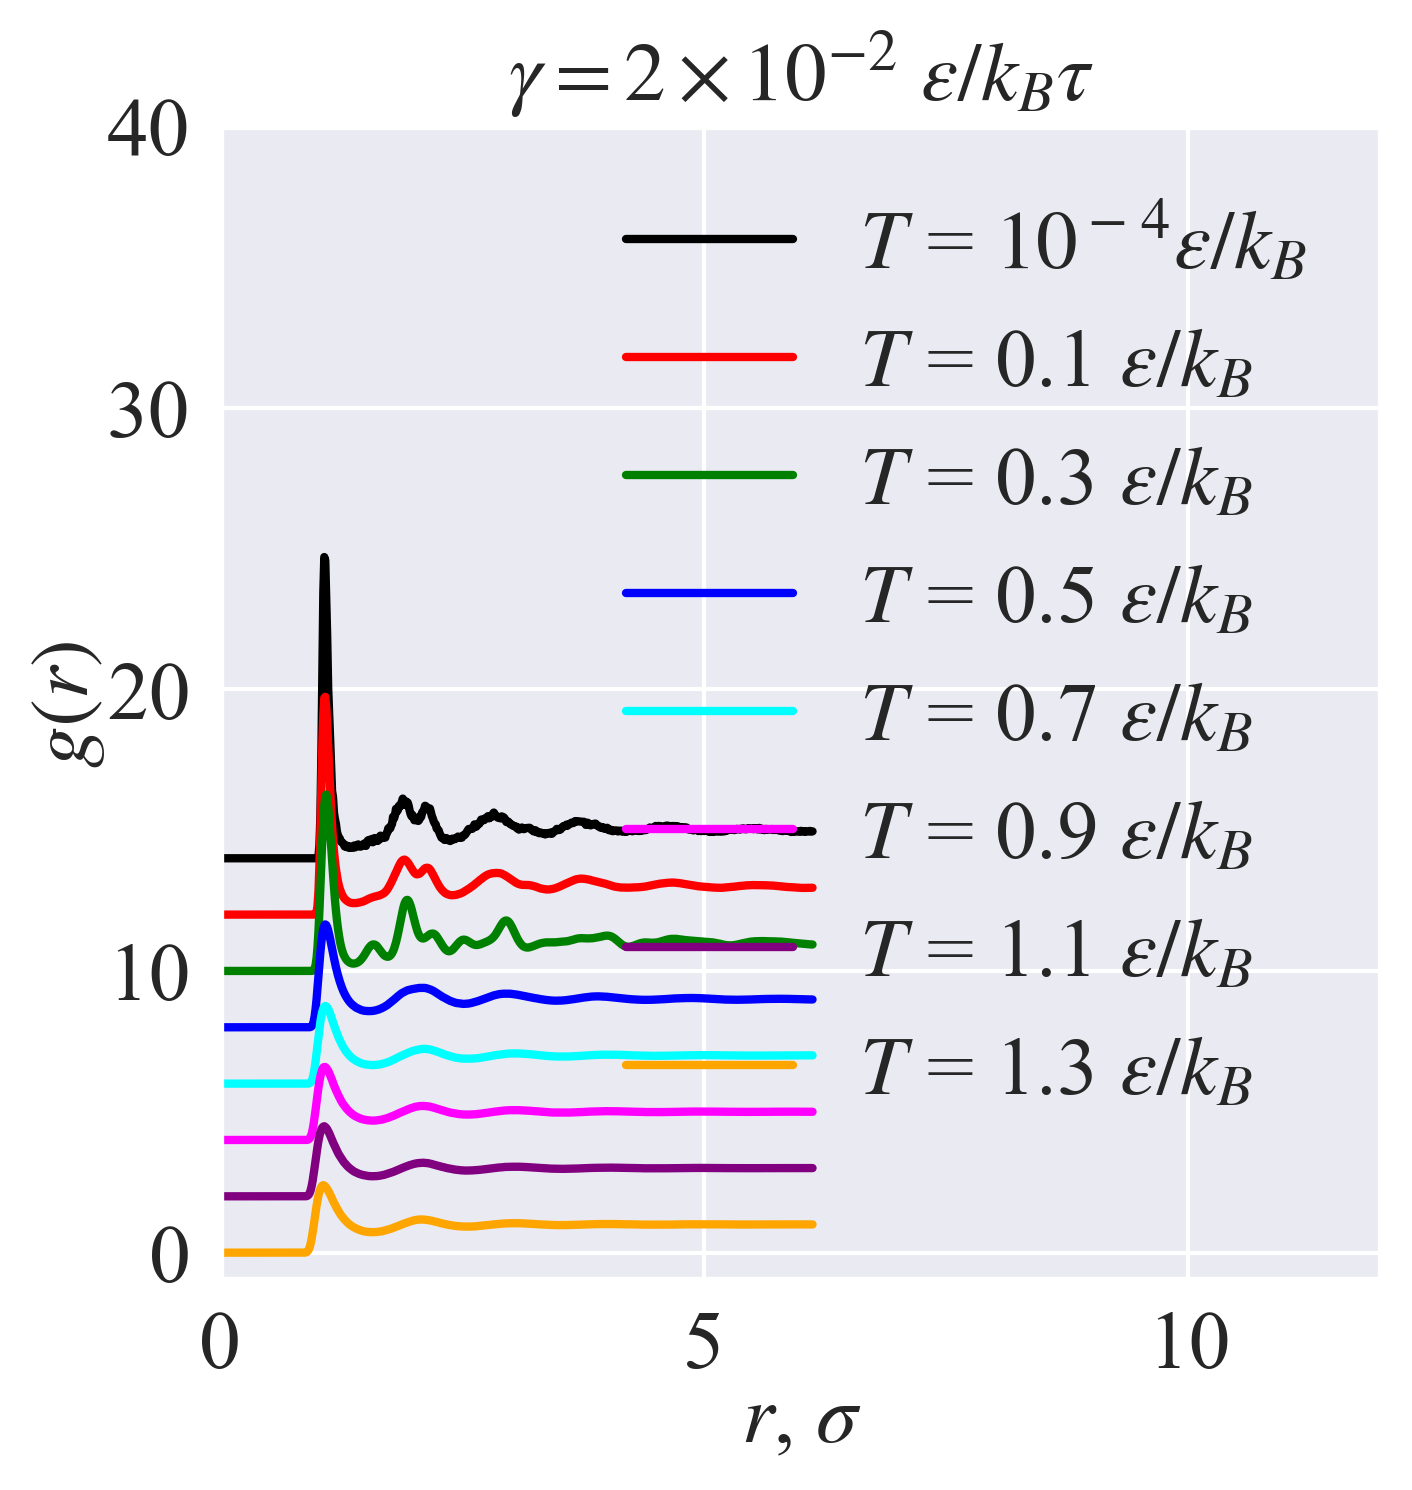

In [12]:
plotter = Plotter(
    path_to_plots=PATH_TO_CURRENT_PLOTS,
    limits=dict(
        left=0,
        right=12,
        bottom=-1,
        top=40,
    ),
    size=(5, 5),
    labels=('radius', 'rdf'),
)

shown=list(range(len(setups_slow)))[-8:]
shift = 2
for i, setup in enumerate(setups_slow):
    if shown is not None and i not in shown:
        continue
    plotter.ax.plot(
        rdf_slow.data['radius'],
        (rdf_slow.data[f'setup_{i}'] + shift * (len(setups_slow) - (i + 1))),
        label=get_temperature_legend(setup["temperature"], accuracy=1),
        color=COLORS[i - shown[0]],
    )

plotter.get_legend()
plotter.set_title(r'$\gamma = 2\times10^{{-2}}~\varepsilon / k_B\tau$')
plotter.save_plot(filename=f'rdf_{PLOT_FILENAME_POSTFIX_SLOW}.png')
plt.show()

## Таблица значений RDF

In [13]:
rdf_table = rdf_slow.get_rdf_table()
rdf_table

radius    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.10  ...  \
setup_18   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_17   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_16   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_15   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_14   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_13   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_12   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_11   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_10   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_9    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_8    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_7    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_6    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_5    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_4    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

radius        6.03      6.04      6.05      6.06      6.07      6.08  \
setup_18  1.003350  1.002675  1.002293  1.002955  1.002743  1.002421   
setup_17  1.002987  1.003192  1.002685  1.002770  1.003351  1.003333   
setup_16  1.003998  1.004165  1.003399  1.003630  1.003837  1.002723   
setup_15  1.005799  1.005500  1.005007  1.004569  1.004429  1.004879   
setup_14  0.995040  0.994903  0.993529  0.993048  0.991428  0.990726   
setup_13  0.959655  0.955868  0.952759  0.949844  0.947331  0.945234   
setup_12  0.948651  0.949226  0.948069  0.948908  0.949315  0.950127   
setup_11  0.961159  0.956274  0.937736  0.948426  0.951990  0.960742   
setup_10  0.961215  0.957829  0.935985  0.950534  0.949635  0.960731   
setup_9   0.964942  0.954916  0.935183  0.952337  0.950798  0.959216   
setup_8   0.966289  0.957274  0.931819  0.951490  0.952924  0.957490   
setup_7   0.966903  0.957427  0.931449  0.951119  0.951294  0.959769   
setup_6   0.964042  0.963665  0.930741  0.955202  0.948906  0.959246   
setup_5   0.964667  0.962810  0.932065  0.953646  0.951039  0.957814   
setup_4   0.969969  0.957682  0.934231  0.949571  0.952832  0.958598   
setup_3   0.967151  0.958227  0.933293  0.952538  0.952731  0.958740   
setup_2   0.968945  0.958517  0.928554  0.952720  0.952403  0.959271   
setup_1   0.965037  0.961958  0.928375  0.957600  0.948810  0.960456   
setup_0   0.965307  0.962022  0.928420  0.957416  0.948243  0.961419   

radius        6.09      6.10      6.11      6.12  
setup_18  1.002688  1.002257  1.002756  1.001890  
setup_17  1.003248  1.003285  1.002972  1.002484  
setup_16  1.003373  1.002961  1.002372  1.001068  
setup_15  1.004958  1.004694  1.004338  1.002657  
setup_14  0.989794  0.988894  0.987592  0.986763  
setup_13  0.943664  0.941891  0.941246  0.939023  
setup_12  0.950737  0.950212  0.952590  0.953631  
setup_11  0.971389  0.949515  0.946567  0.955499  
setup_10  0.972548  0.948919  0.947611  0.956192  
setup_9   0.972193  0.950129  0.946929  0.956895  
setup_8   0.973695  0.950200  0.945115  0.958129  
setup_7   0.973811  0.950257  0.944083  0.960054  
setup_6   0.972041  0.959568  0.936014  0.961909  
setup_5   0.972463  0.958827  0.936951  0.961087  
setup_4   0.977900  0.953940  0.938700  0.959647  
setup_3   0.973231  0.957610  0.937581  0.959298  
setup_2   0.974323  0.950714  0.941542  0.961679  
setup_1   0.975253  0.953928  0.939945  0.958453  
setup_0   0.974466  0.954046  0.940239  0.958419 

## Температура системы как признак модели

In [14]:
temperatures = np.array([
    setups_slow[value]['temperature']
    for value
    in rdf_table.index.str[6:].values.astype(np.int32)
])
samples = temperatures[:, np.newaxis]
samples

array([[1.30075e+00],
       [1.10086e+00],
       [9.01880e-01],
       [7.00120e-01],
       [4.99300e-01],
       [3.01170e-01],
       [1.01510e-01],
       [1.30000e-04],
       [1.30000e-04],
       [1.30000e-04],
       [1.30000e-04],
       [1.30000e-04],
       [1.30000e-04],
       [1.30000e-04],
       [1.30000e-04],
       [1.30000e-04],
       [1.30000e-04],
       [1.20000e-04],
       [1.20000e-04]])

In [15]:
np.random.seed(0)
samples_indices = np.arange(samples.shape[0])
np.random.shuffle(samples_indices)
samples_train_indices = samples_indices[:samples_indices.size // 2]
samples_test_indices = samples_indices[samples_indices.size // 2:]

train_samples = samples[samples_train_indices]
test_samples = samples[samples_test_indices]

samples_train_indices, samples_test_indices

(array([10,  1,  8, 18, 14, 16,  6,  4,  2]),
 array([ 5, 13,  9,  7, 17, 11,  3,  0, 15, 12]))

In [16]:
train_samples, test_samples

(array([[1.30000e-04],
        [1.10086e+00],
        [1.30000e-04],
        [1.20000e-04],
        [1.30000e-04],
        [1.30000e-04],
        [1.01510e-01],
        [4.99300e-01],
        [9.01880e-01]]),
 array([[3.01170e-01],
        [1.30000e-04],
        [1.30000e-04],
        [1.30000e-04],
        [1.20000e-04],
        [1.30000e-04],
        [7.00120e-01],
        [1.30075e+00],
        [1.30000e-04],
        [1.30000e-04]]))

## Настройка гиперпараметров

In [17]:
# regressors = {
#     'linear': LinearRegression(), 
#     'k_neighbors_uniform': KNeighborsRegressor(weights='uniform'), 
#     'k_neighbors_distance': KNeighborsRegressor(weights='distance'), 
#     'r_neighbors_uniform': RadiusNeighborsRegressor(weights='uniform'), 
#     'r_neighbors_distance': RadiusNeighborsRegressor(weights='distance'), 
#     'decision_tree': DecisionTreeRegressor(),
# }
# scores = {key: [] for key in regressors.keys()}
# param_names = {
#     'k_neighbors_uniform': 'n_neighbors', 
#     'k_neighbors_distance': 'n_neighbors', 
#     'r_neighbors_uniform': 'radius', 
#     'r_neighbors_distance': 'radius',
#     'decision_tree': 'max_depth',
# }
# param_ranges = {
#     'k_neighbors_uniform': np.arange(1, 15),
#     'k_neighbors_distance': np.arange(1, 15),
#     'r_neighbors_uniform': np.linspace(0.4, 1.3, 10),
#     'r_neighbors_distance': np.linspace(0.4, 1.3, 10),
#     'decision_tree': np.arange(1, 15),
# }

# for i, column in enumerate(rdf_table.columns):
#     print(f'Step: {i + 1} / {rdf_table.columns.shape[0]}')
#     train_targets = rdf_table[column].values[samples_train_indices]
#     if not train_targets.any():
#         continue
#     for key in list(regressors.keys())[1:]:
#         _, test_scores = validation_curve(
#             regressors[key],
#             train_samples, train_targets,
#             param_name=param_names[key],
#             param_range=np.arange(1, 9),
#             scoring='neg_mean_squared_error',
#             cv=train_samples.shape[0],
#         )
#         scores[key].append(np.mean(test_scores, axis=1).argmax())

# best_hyperparameters = {}
# for key, value in scores.items():
#     if value:
#         best_hyperparameters[key] = param_ranges[key][
#             Counter(value).most_common(1)[0][0]
#         ]
        
# best_hyperparameters

## Обучение модели

In [18]:
regressors_list = []
scores_dict = {
    'linear': [],
    'k_neighbors_uniform': [],
    'k_neighbors_distance': [],
    'r_neighbors_uniform': [],
    'r_neighbors_distance': [],
    'decision_tree': [],
}

for i, column in enumerate(rdf_table.columns):
    print(f'Step: {i + 1} / {rdf_table.columns.shape[0]}')
    train_targets = rdf_table[column].values[samples_train_indices]
    regressors = {
        'linear': LinearRegression(),
        'k_neighbors_uniform': KNeighborsRegressor(n_neighbors=1, weights='uniform'),
        'k_neighbors_distance': KNeighborsRegressor(n_neighbors=1, weights='distance'),
        'r_neighbors_uniform': RadiusNeighborsRegressor(radius=0.4, weights='uniform'),
        'r_neighbors_distance': RadiusNeighborsRegressor(radius=0.4, weights='distance'),
        'decision_tree': DecisionTreeRegressor(max_depth=2,),
    }
    for key, value in regressors.items():
        score = cross_val_score(
            value, 
            train_samples, train_targets,
            scoring='neg_mean_squared_error',
            cv=train_samples.shape[0],
        ).mean()
        scores_dict[key].append(score)
        regressors[key].fit(train_samples, train_targets)
    regressors_list.append(regressors)

for key, value in scores_dict.items():
    scores_dict[key] = np.array(value)

Step: 1 / 612
Step: 2 / 612
Step: 3 / 612
Step: 4 / 612
Step: 5 / 612
Step: 6 / 612
Step: 7 / 612
Step: 8 / 612
Step: 9 / 612
Step: 10 / 612
Step: 11 / 612
Step: 12 / 612
Step: 13 / 612
Step: 14 / 612
Step: 15 / 612
Step: 16 / 612
Step: 17 / 612
Step: 18 / 612
Step: 19 / 612
Step: 20 / 612
Step: 21 / 612
Step: 22 / 612
Step: 23 / 612
Step: 24 / 612
Step: 25 / 612
Step: 26 / 612
Step: 27 / 612
Step: 28 / 612
Step: 29 / 612
Step: 30 / 612
Step: 31 / 612
Step: 32 / 612
Step: 33 / 612
Step: 34 / 612
Step: 35 / 612
Step: 36 / 612
Step: 37 / 612
Step: 38 / 612
Step: 39 / 612
Step: 40 / 612
Step: 41 / 612
Step: 42 / 612
Step: 43 / 612
Step: 44 / 612
Step: 45 / 612
Step: 46 / 612
Step: 47 / 612
Step: 48 / 612
Step: 49 / 612
Step: 50 / 612
Step: 51 / 612
Step: 52 / 612
Step: 53 / 612
Step: 54 / 612
Step: 55 / 612
Step: 56 / 612
Step: 57 / 612
Step: 58 / 612
Step: 59 / 612
Step: 60 / 612
Step: 61 / 612
Step: 62 / 612
Step: 63 / 612
Step: 64 / 612
Step: 65 / 612
Step: 66 / 612
Step: 67 / 612
Step

Step: 521 / 612
Step: 522 / 612
Step: 523 / 612
Step: 524 / 612
Step: 525 / 612
Step: 526 / 612
Step: 527 / 612
Step: 528 / 612
Step: 529 / 612
Step: 530 / 612
Step: 531 / 612
Step: 532 / 612
Step: 533 / 612
Step: 534 / 612
Step: 535 / 612
Step: 536 / 612
Step: 537 / 612
Step: 538 / 612
Step: 539 / 612
Step: 540 / 612
Step: 541 / 612
Step: 542 / 612
Step: 543 / 612
Step: 544 / 612
Step: 545 / 612
Step: 546 / 612
Step: 547 / 612
Step: 548 / 612
Step: 549 / 612
Step: 550 / 612
Step: 551 / 612
Step: 552 / 612
Step: 553 / 612
Step: 554 / 612
Step: 555 / 612
Step: 556 / 612
Step: 557 / 612
Step: 558 / 612
Step: 559 / 612
Step: 560 / 612
Step: 561 / 612
Step: 562 / 612
Step: 563 / 612
Step: 564 / 612
Step: 565 / 612
Step: 566 / 612
Step: 567 / 612
Step: 568 / 612
Step: 569 / 612
Step: 570 / 612
Step: 571 / 612
Step: 572 / 612
Step: 573 / 612
Step: 574 / 612
Step: 575 / 612
Step: 576 / 612
Step: 577 / 612
Step: 578 / 612
Step: 579 / 612
Step: 580 / 612
Step: 581 / 612
Step: 582 / 612
Step: 58

## Визуализация ошибок

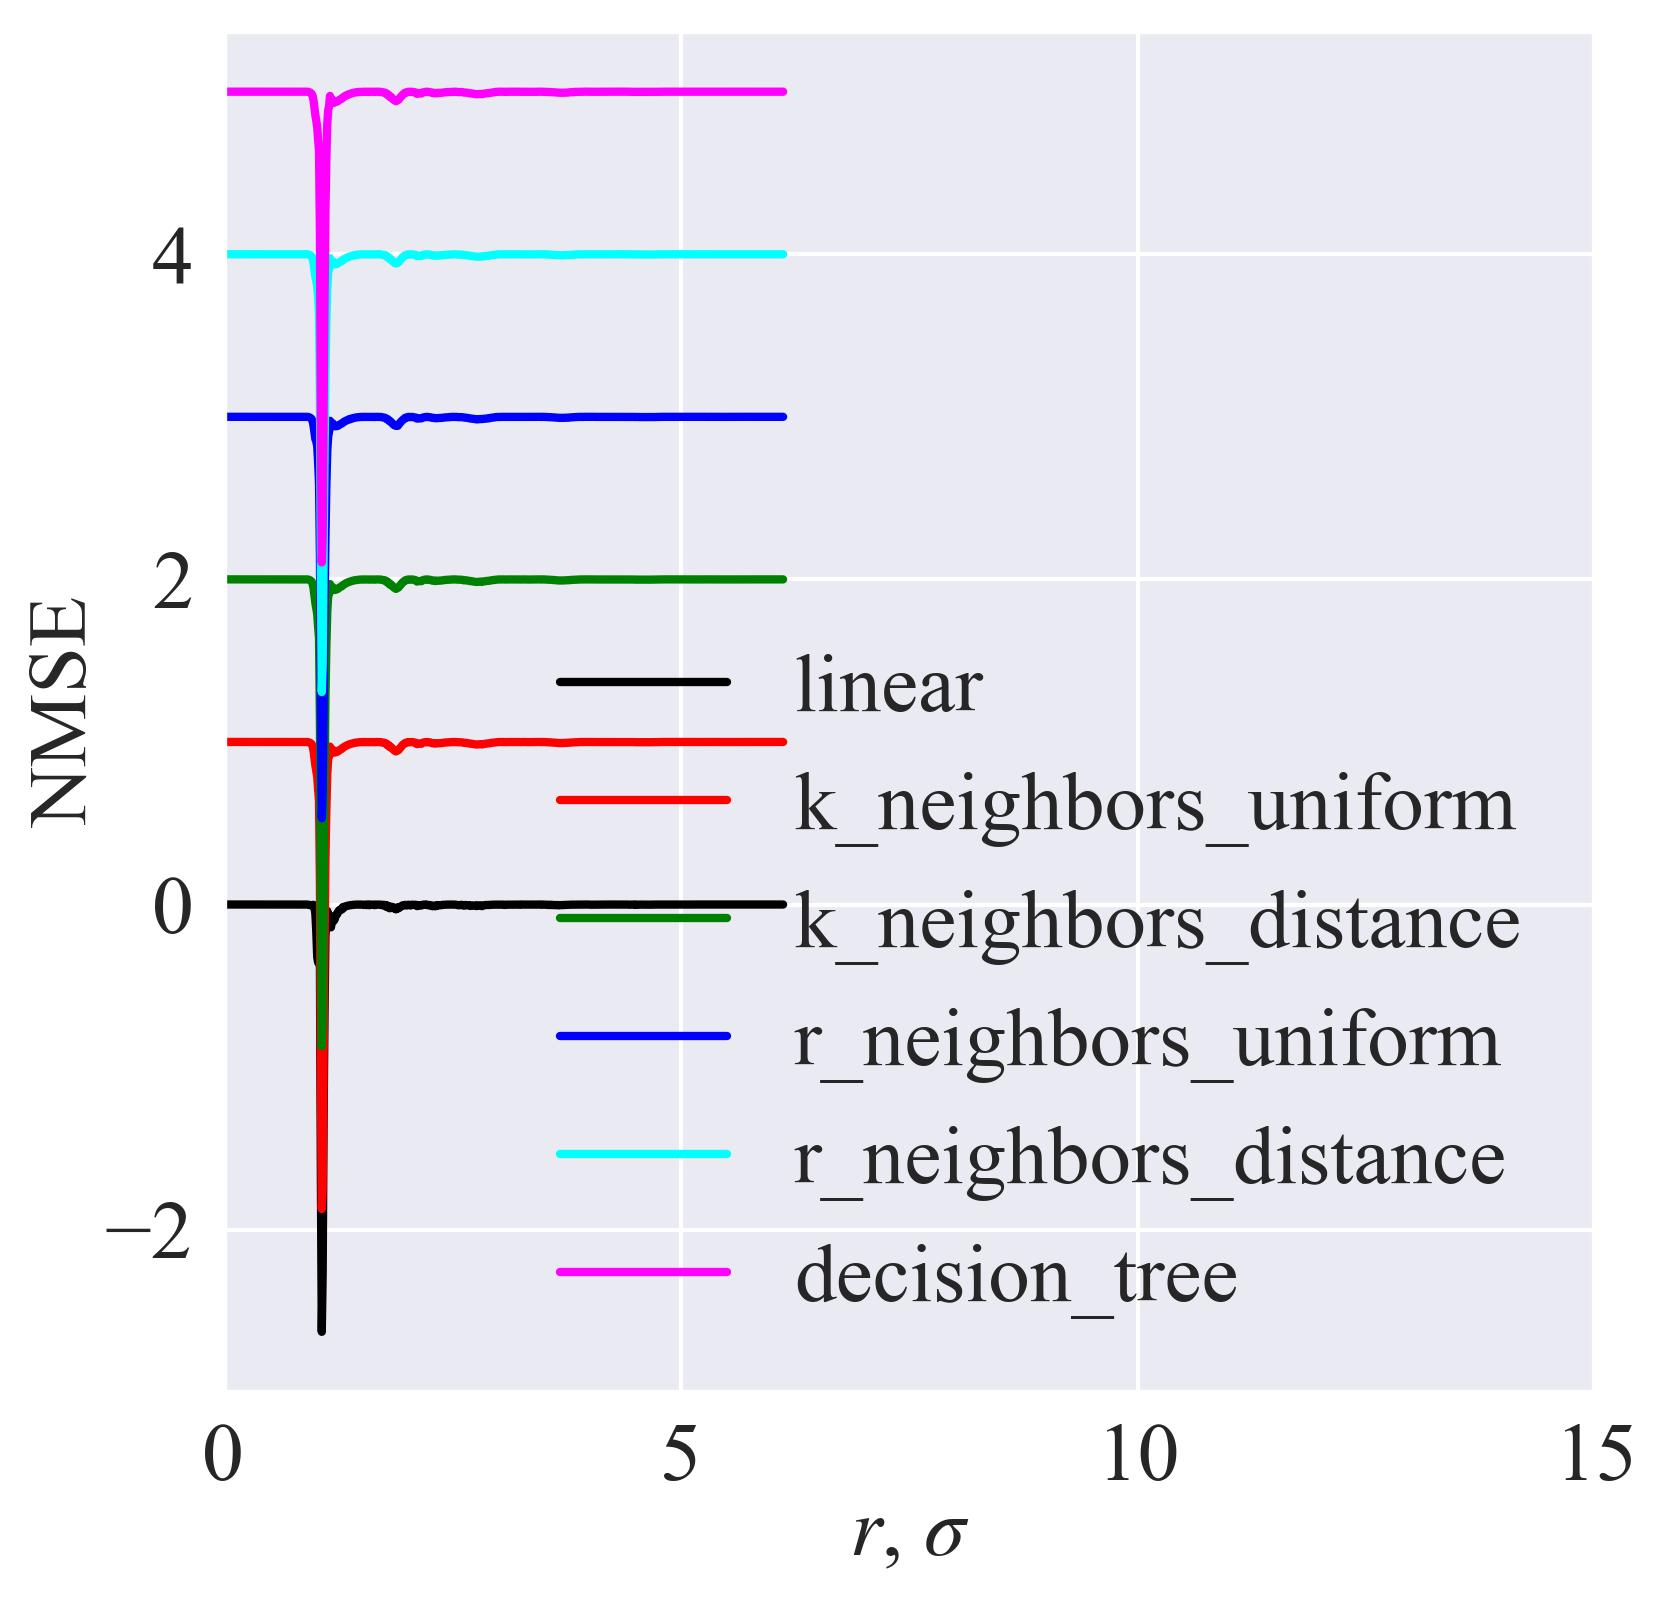

In [19]:
i = 0
for key, value in scores_dict.items():
    plt.plot(
        rdf_slow.data['radius'],
        value + i, label=key, 
        color=COLORS[i],
    )
    i += 1
plt.legend()
plt.xlim(
    left=0.0,
    right=15,
)
plt.ylim(
    #     top=0.01,
    #     bottom=-0.25,
)
plt.xlabel(r'$r$, $\sigma $')
plt.ylabel('NMSE')
save_plot('mse_after_cv')

In [20]:
predicted_temperatures = np.array(test_samples)

predicted_rdf_points = {
    regressor: {key: [] for key in predicted_temperatures[:, 0]}
    for regressor in scores_dict.keys()
}

for item in regressors_list:
    for key, value in item.items():
        predicted_data = value.predict(predicted_temperatures)
        for _key, _ in predicted_rdf_points[key].items():
            predicted_rdf_points[key][_key].append(
                predicted_data[np.where(predicted_temperatures[:, 0] == _key)][0]
            )

for key, value in predicted_rdf_points.items():
    for _key, _value in value.items():
        predicted_rdf_points[key][_key] = np.array(_value)

In [21]:
for i, temperature in zip(samples_test_indices, predicted_temperatures):
    print(i, temperature[0])

5 0.30117
13 0.00013
9 0.00013
7 0.00013
17 0.00012
11 0.00013
3 0.70012
0 1.30075
15 0.00013
12 0.00013


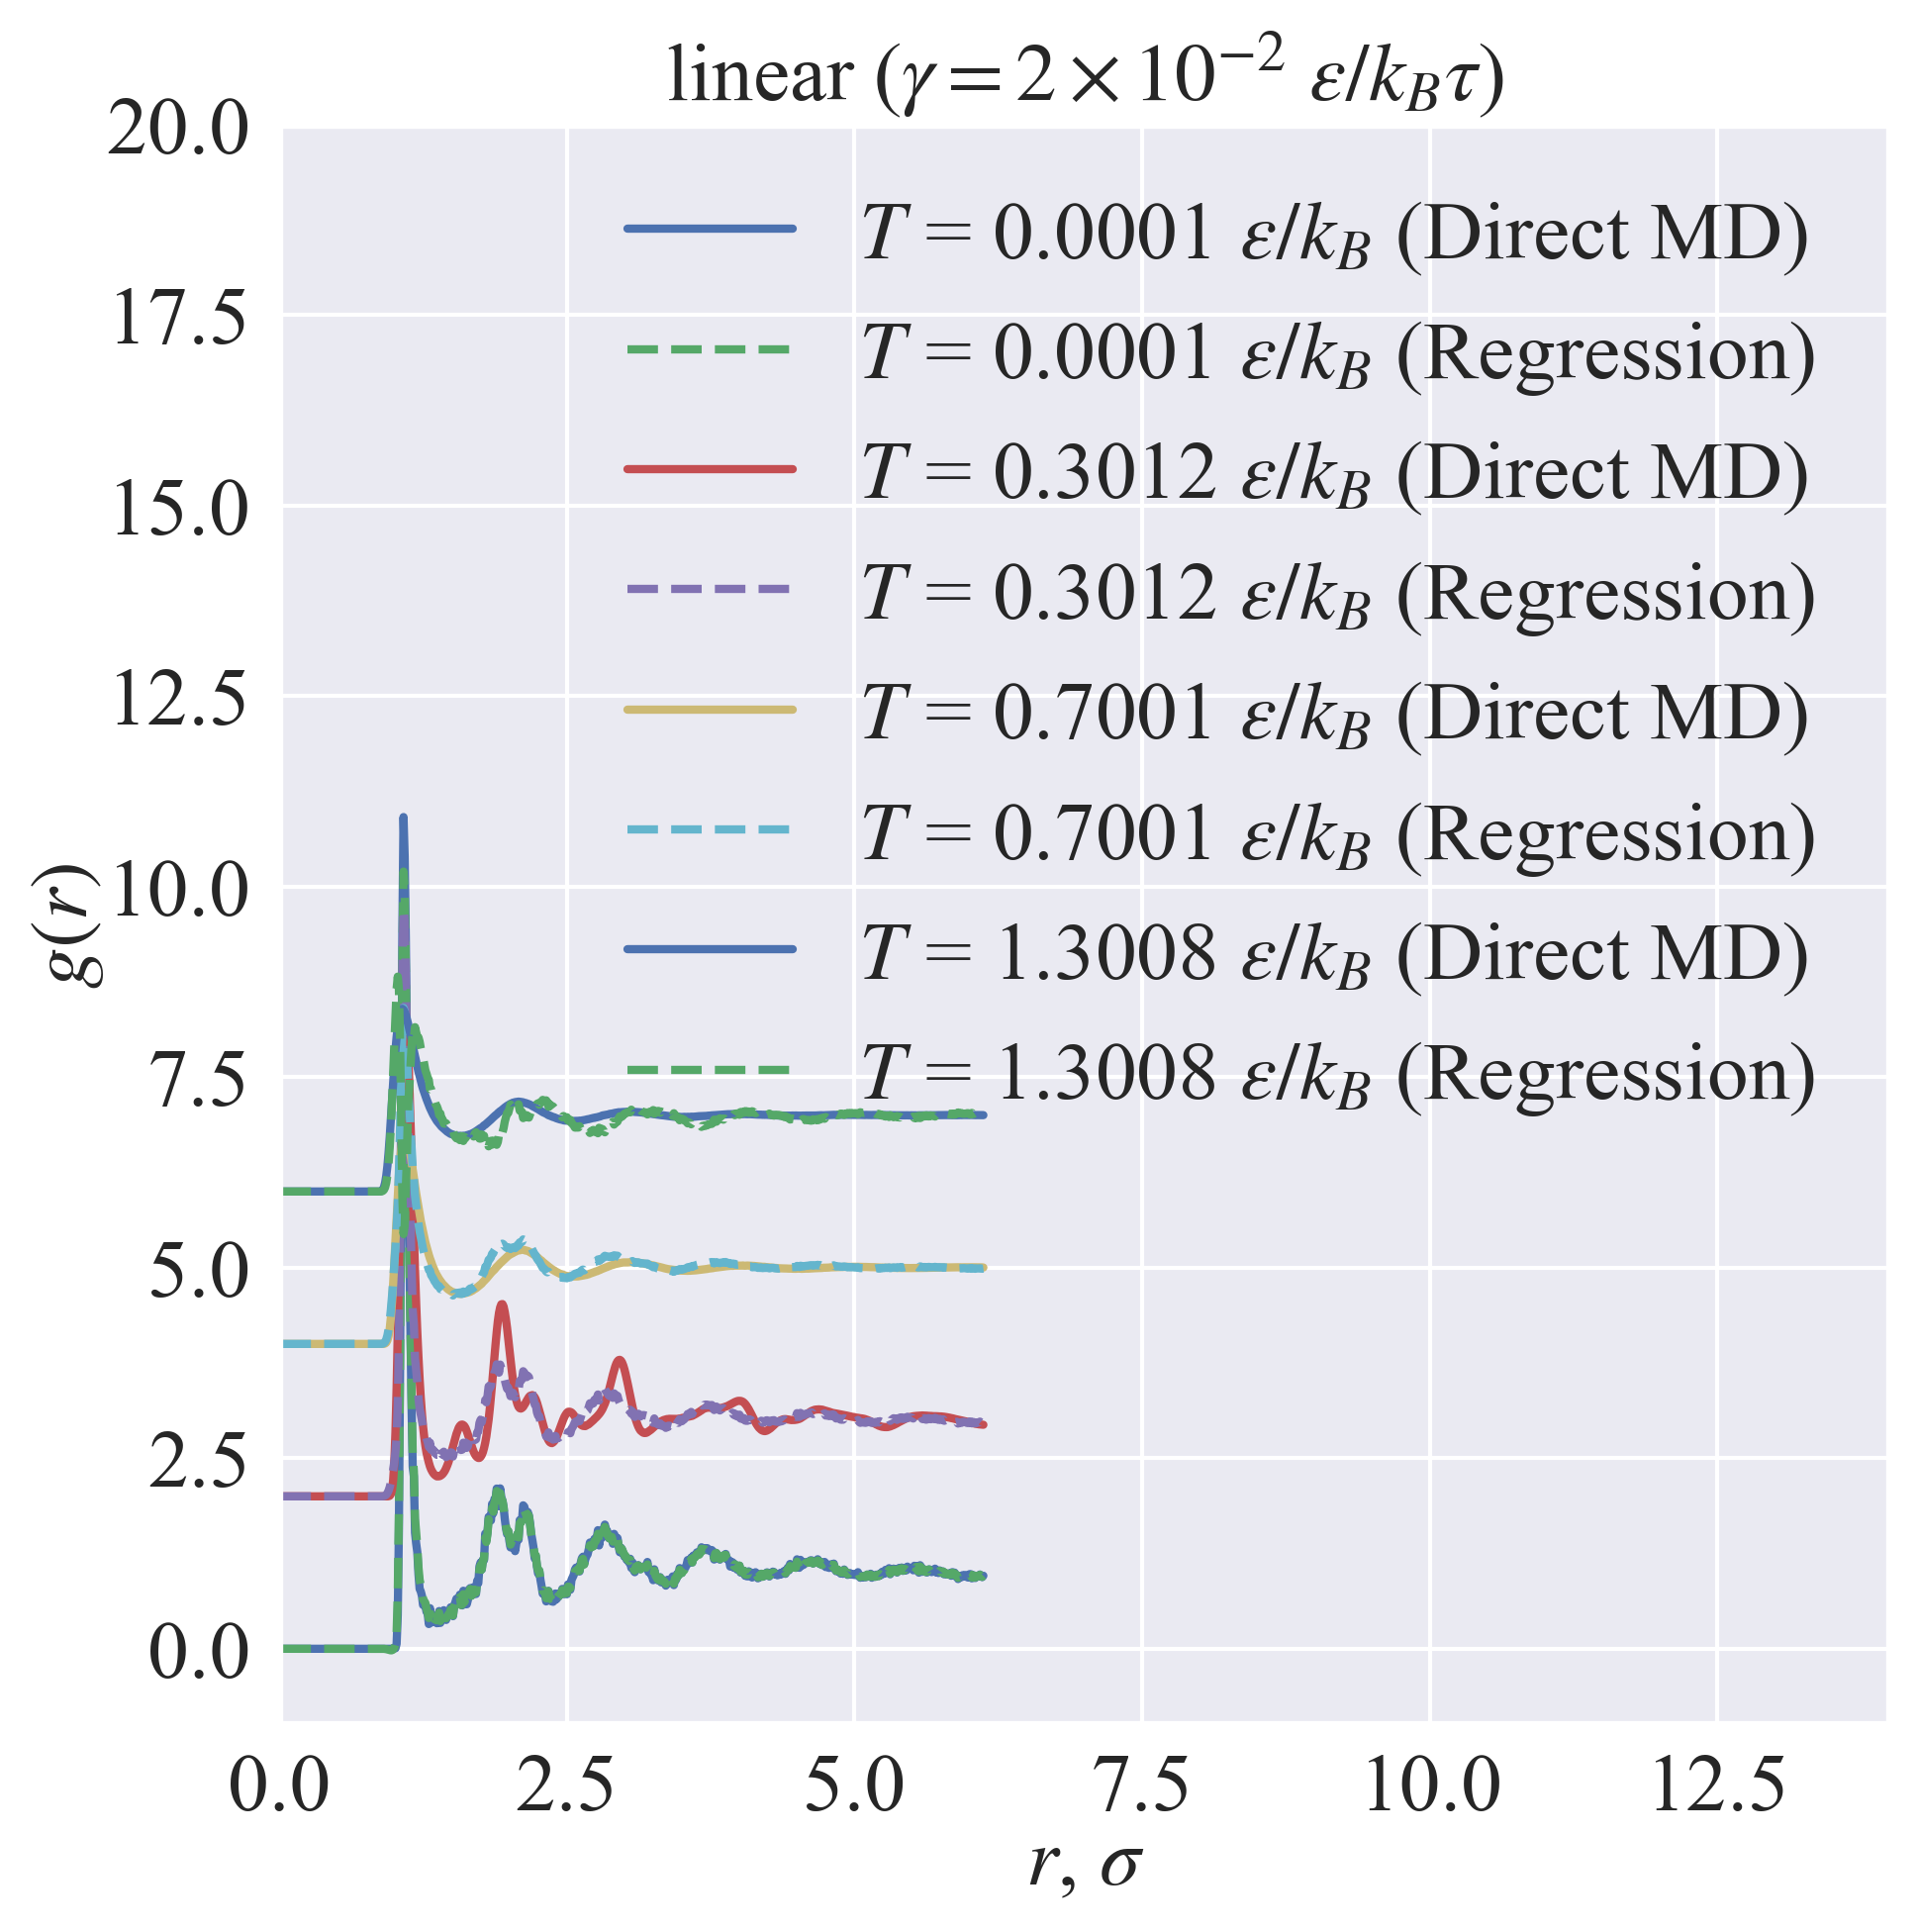

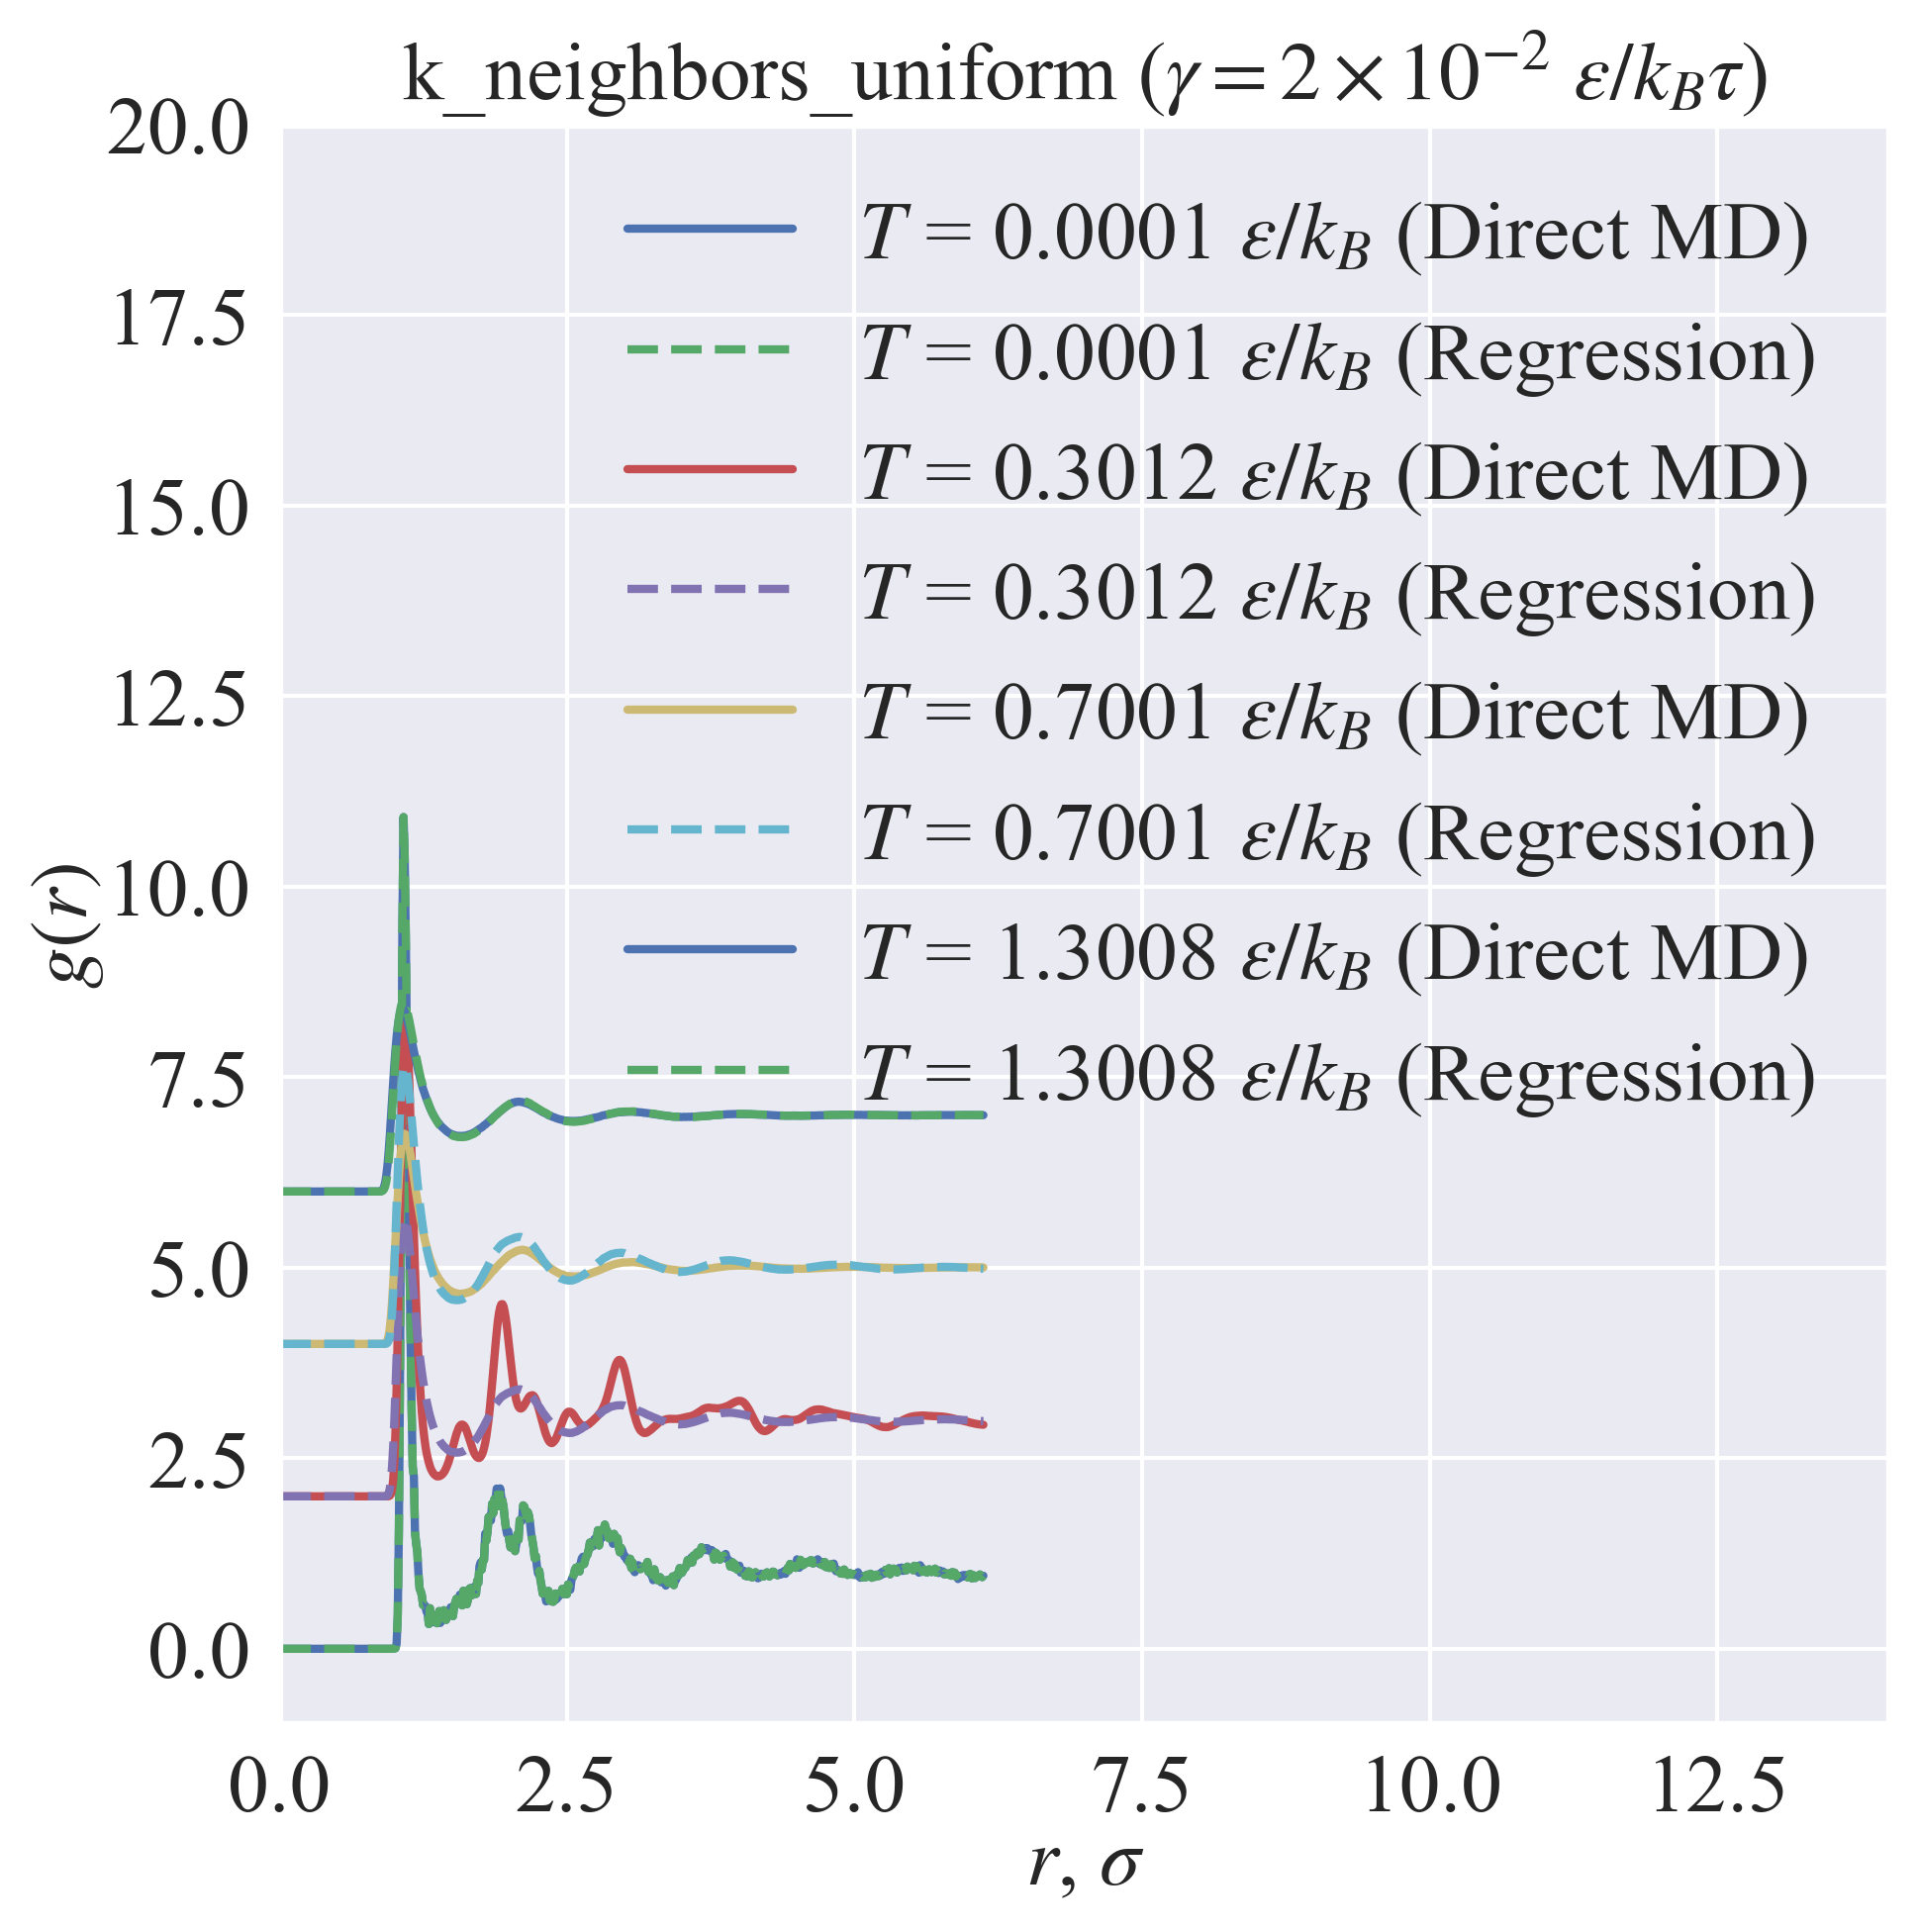

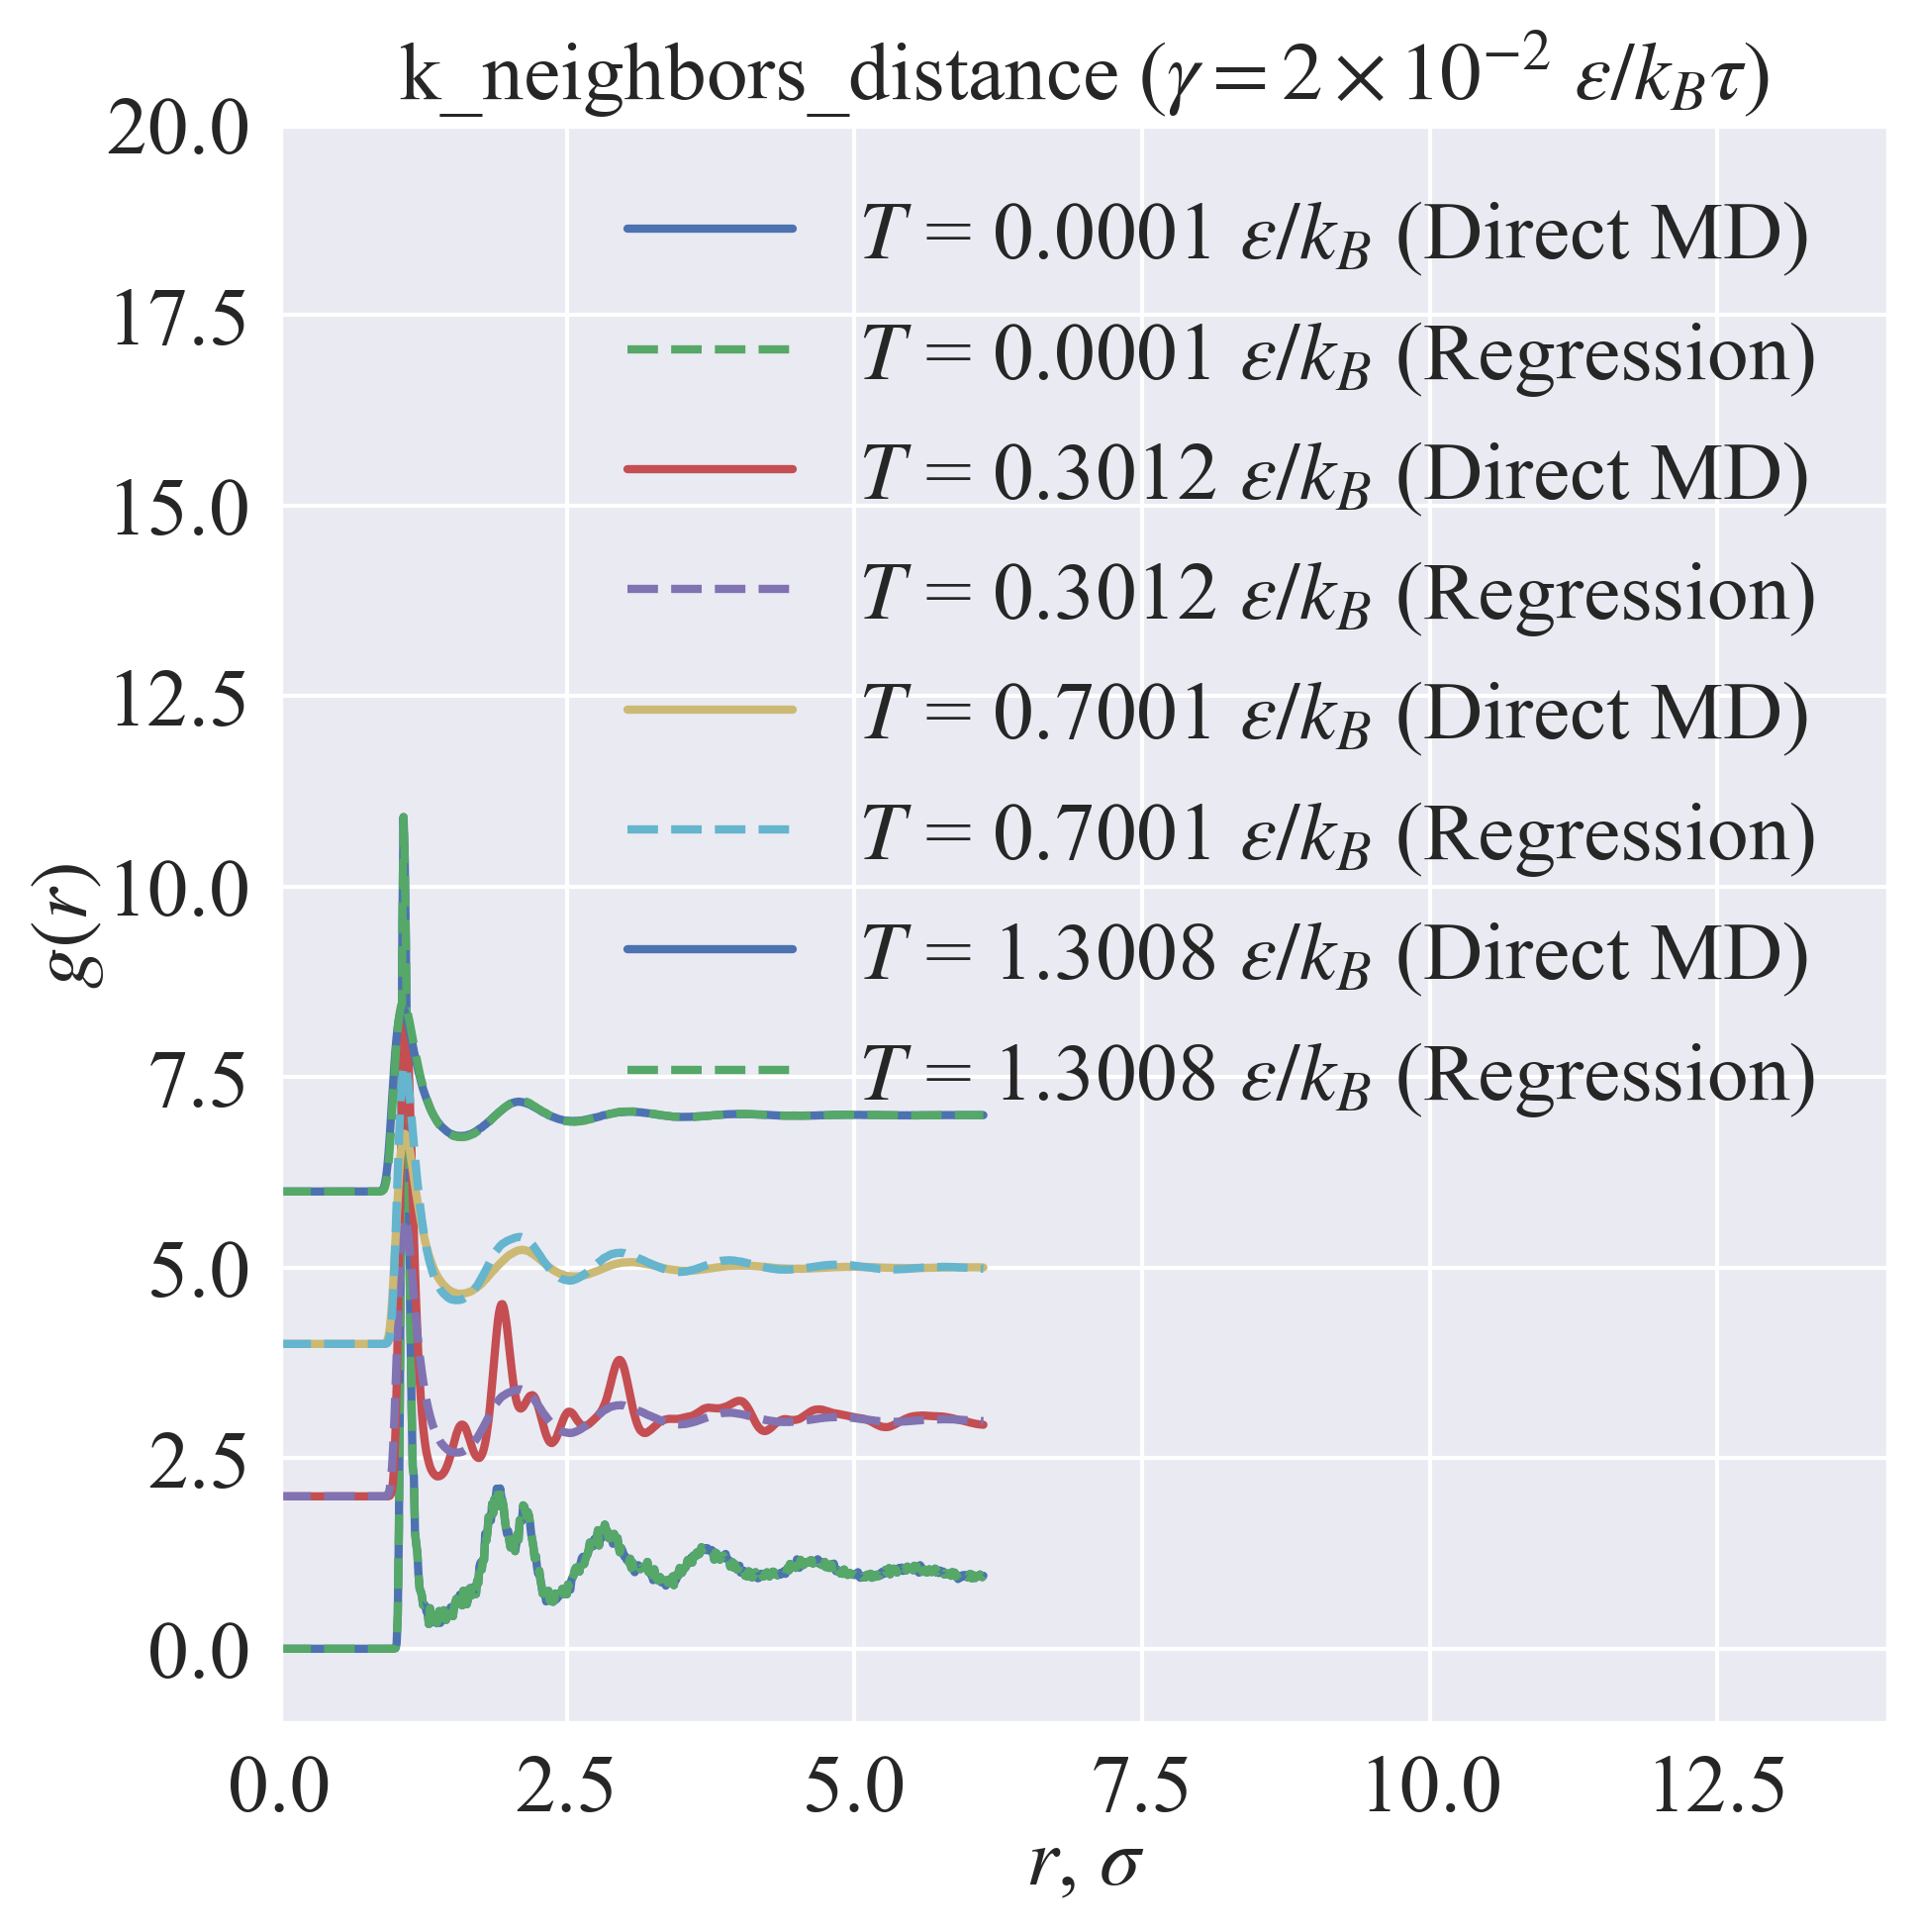

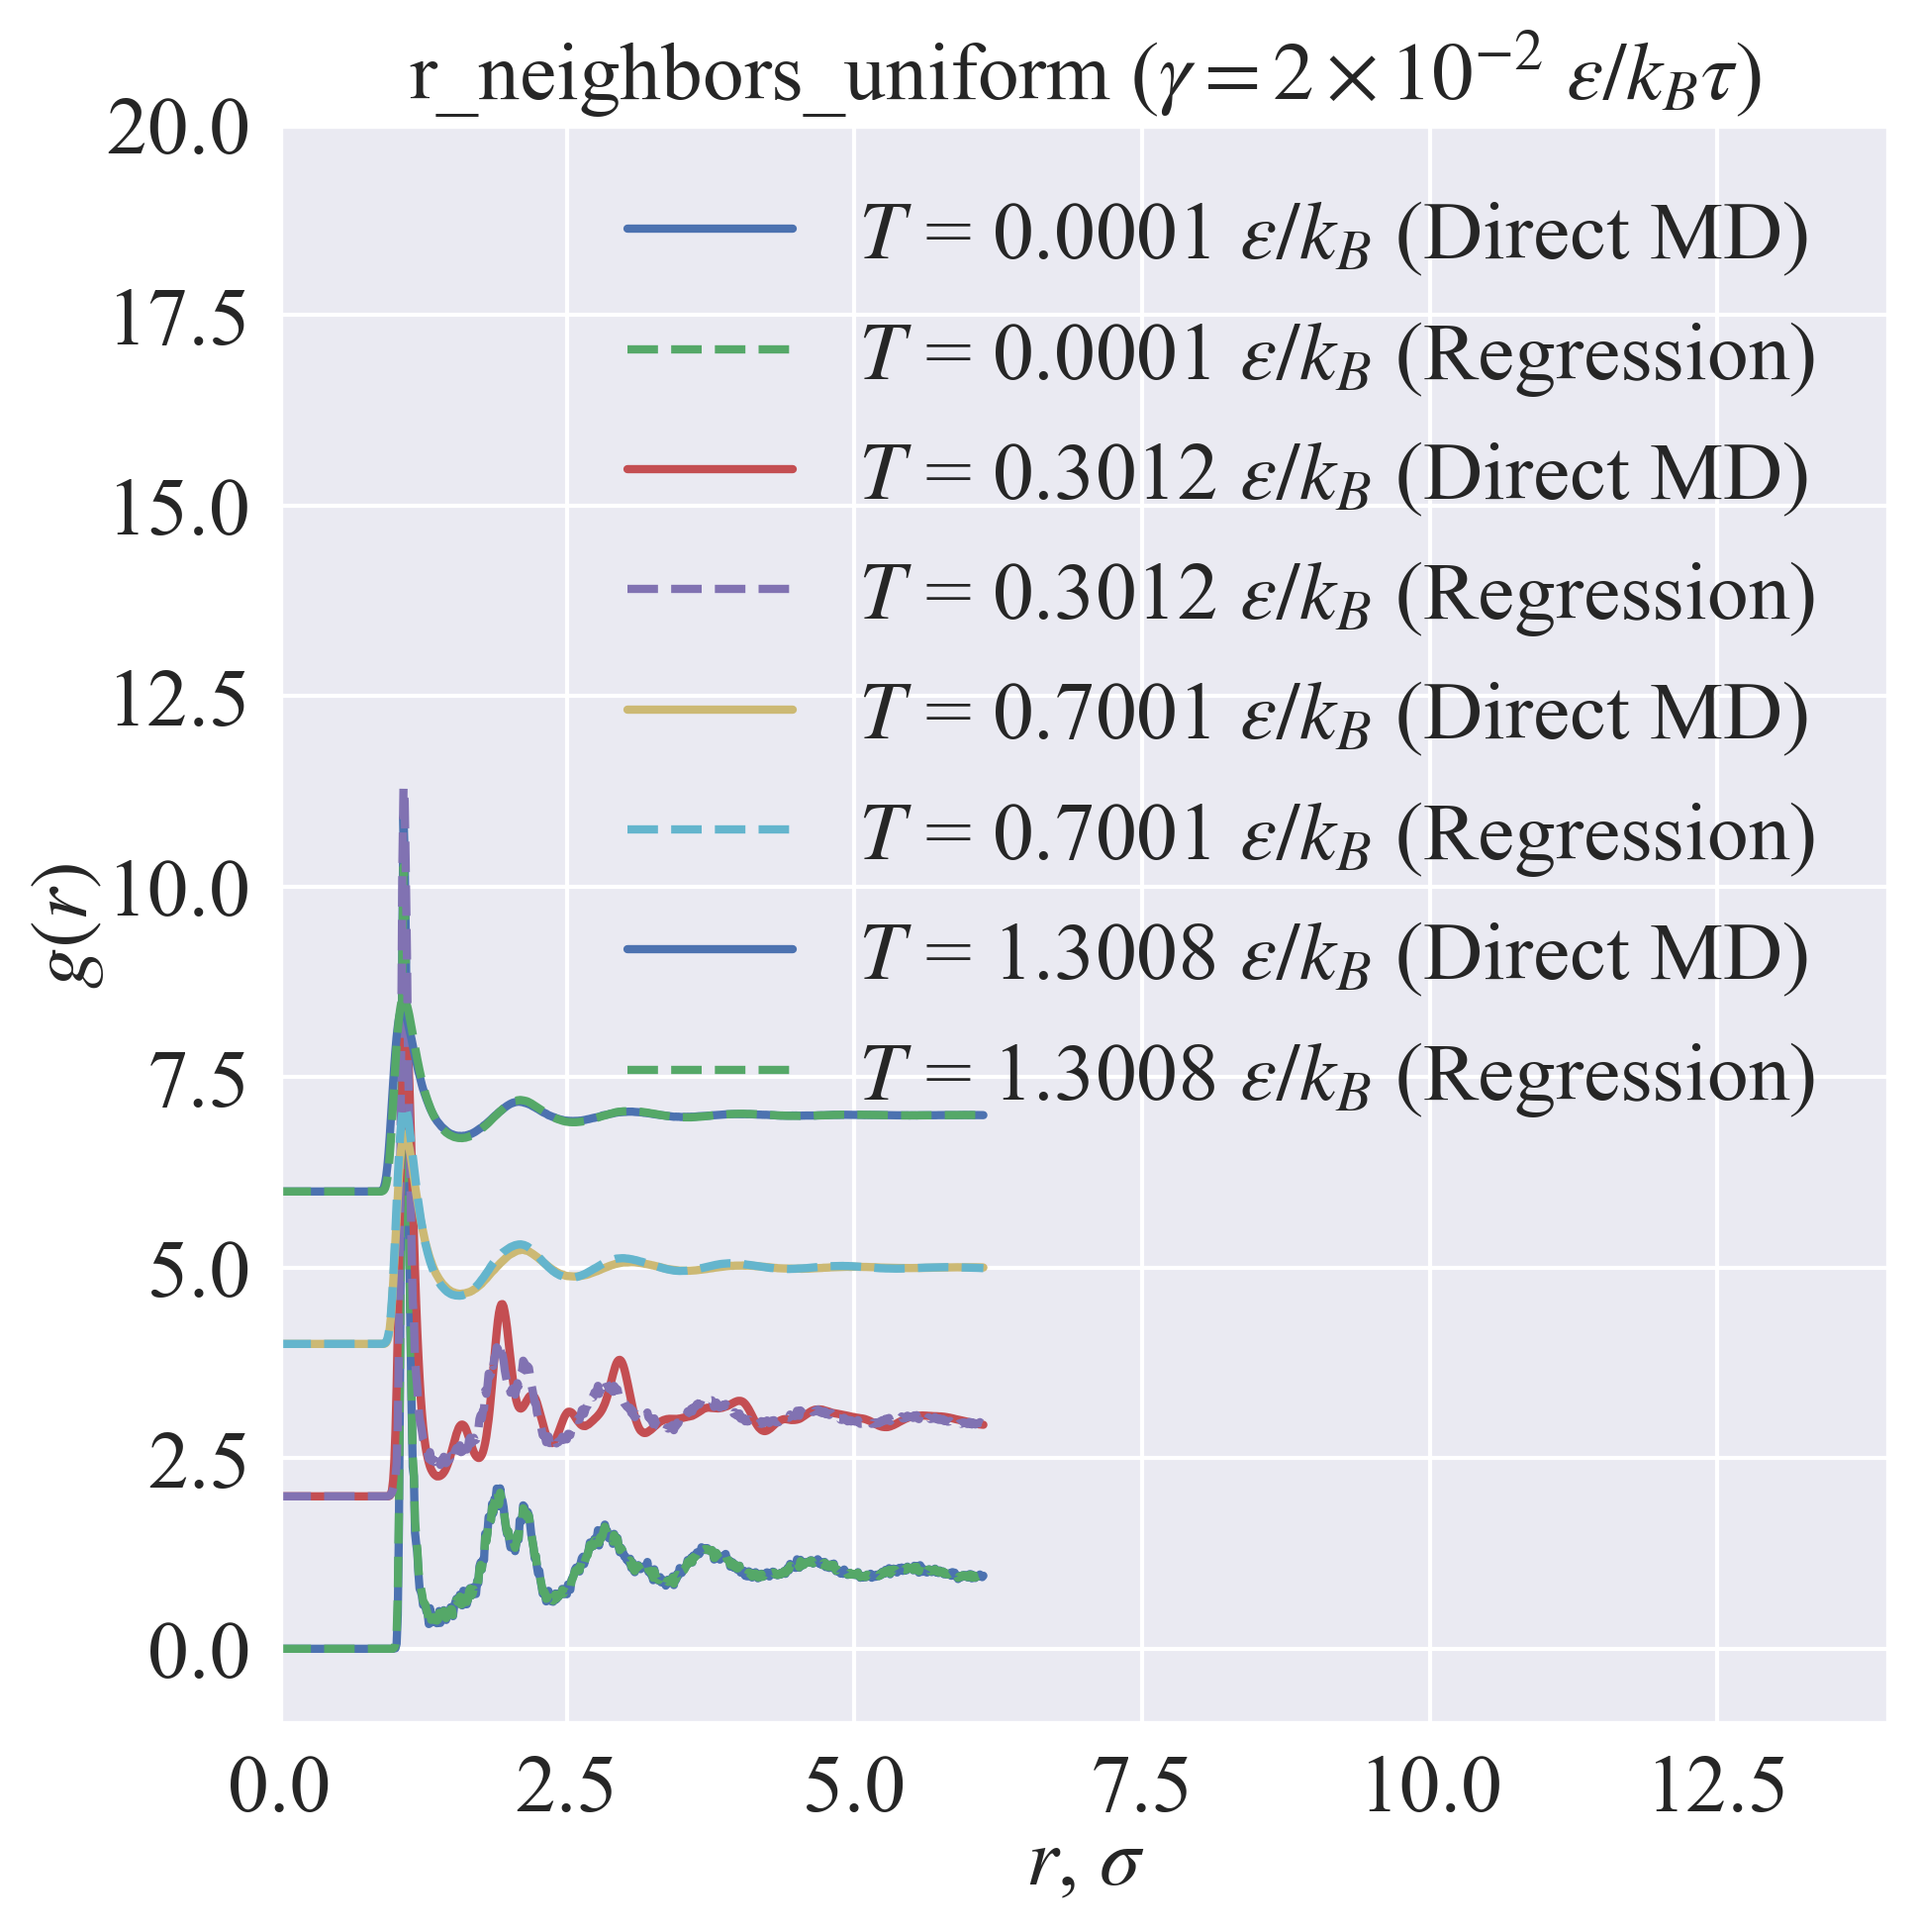

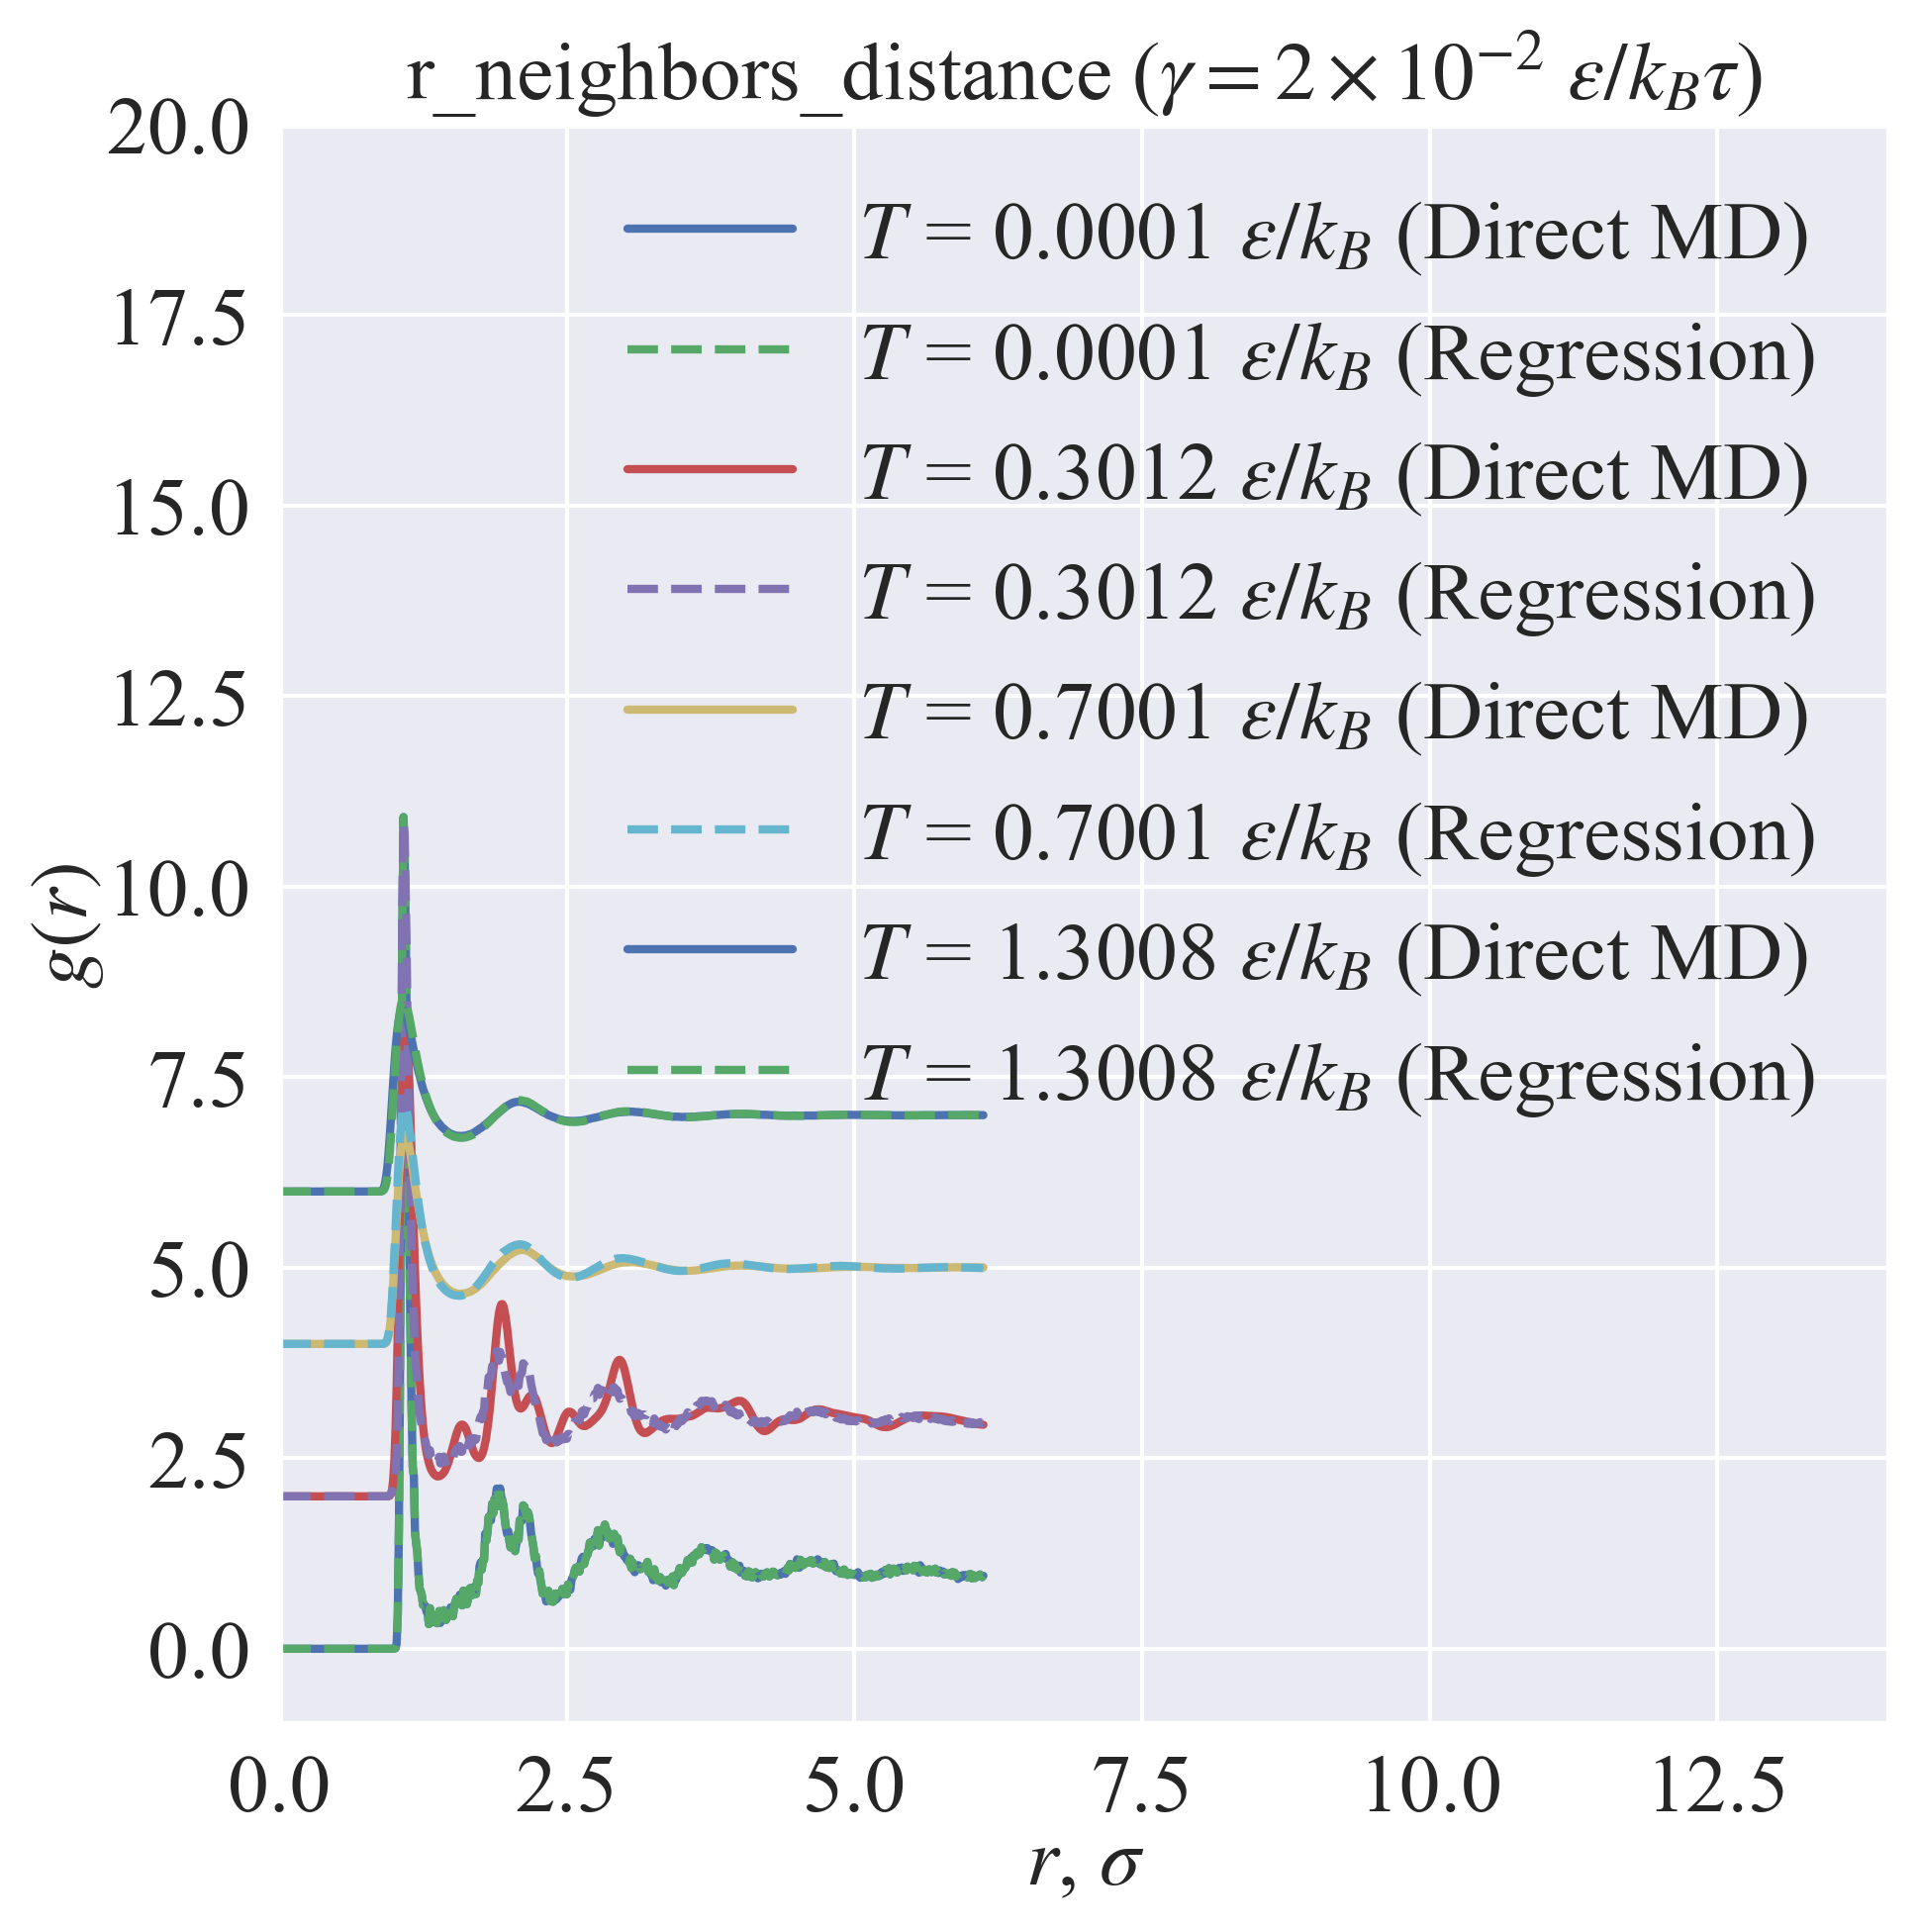

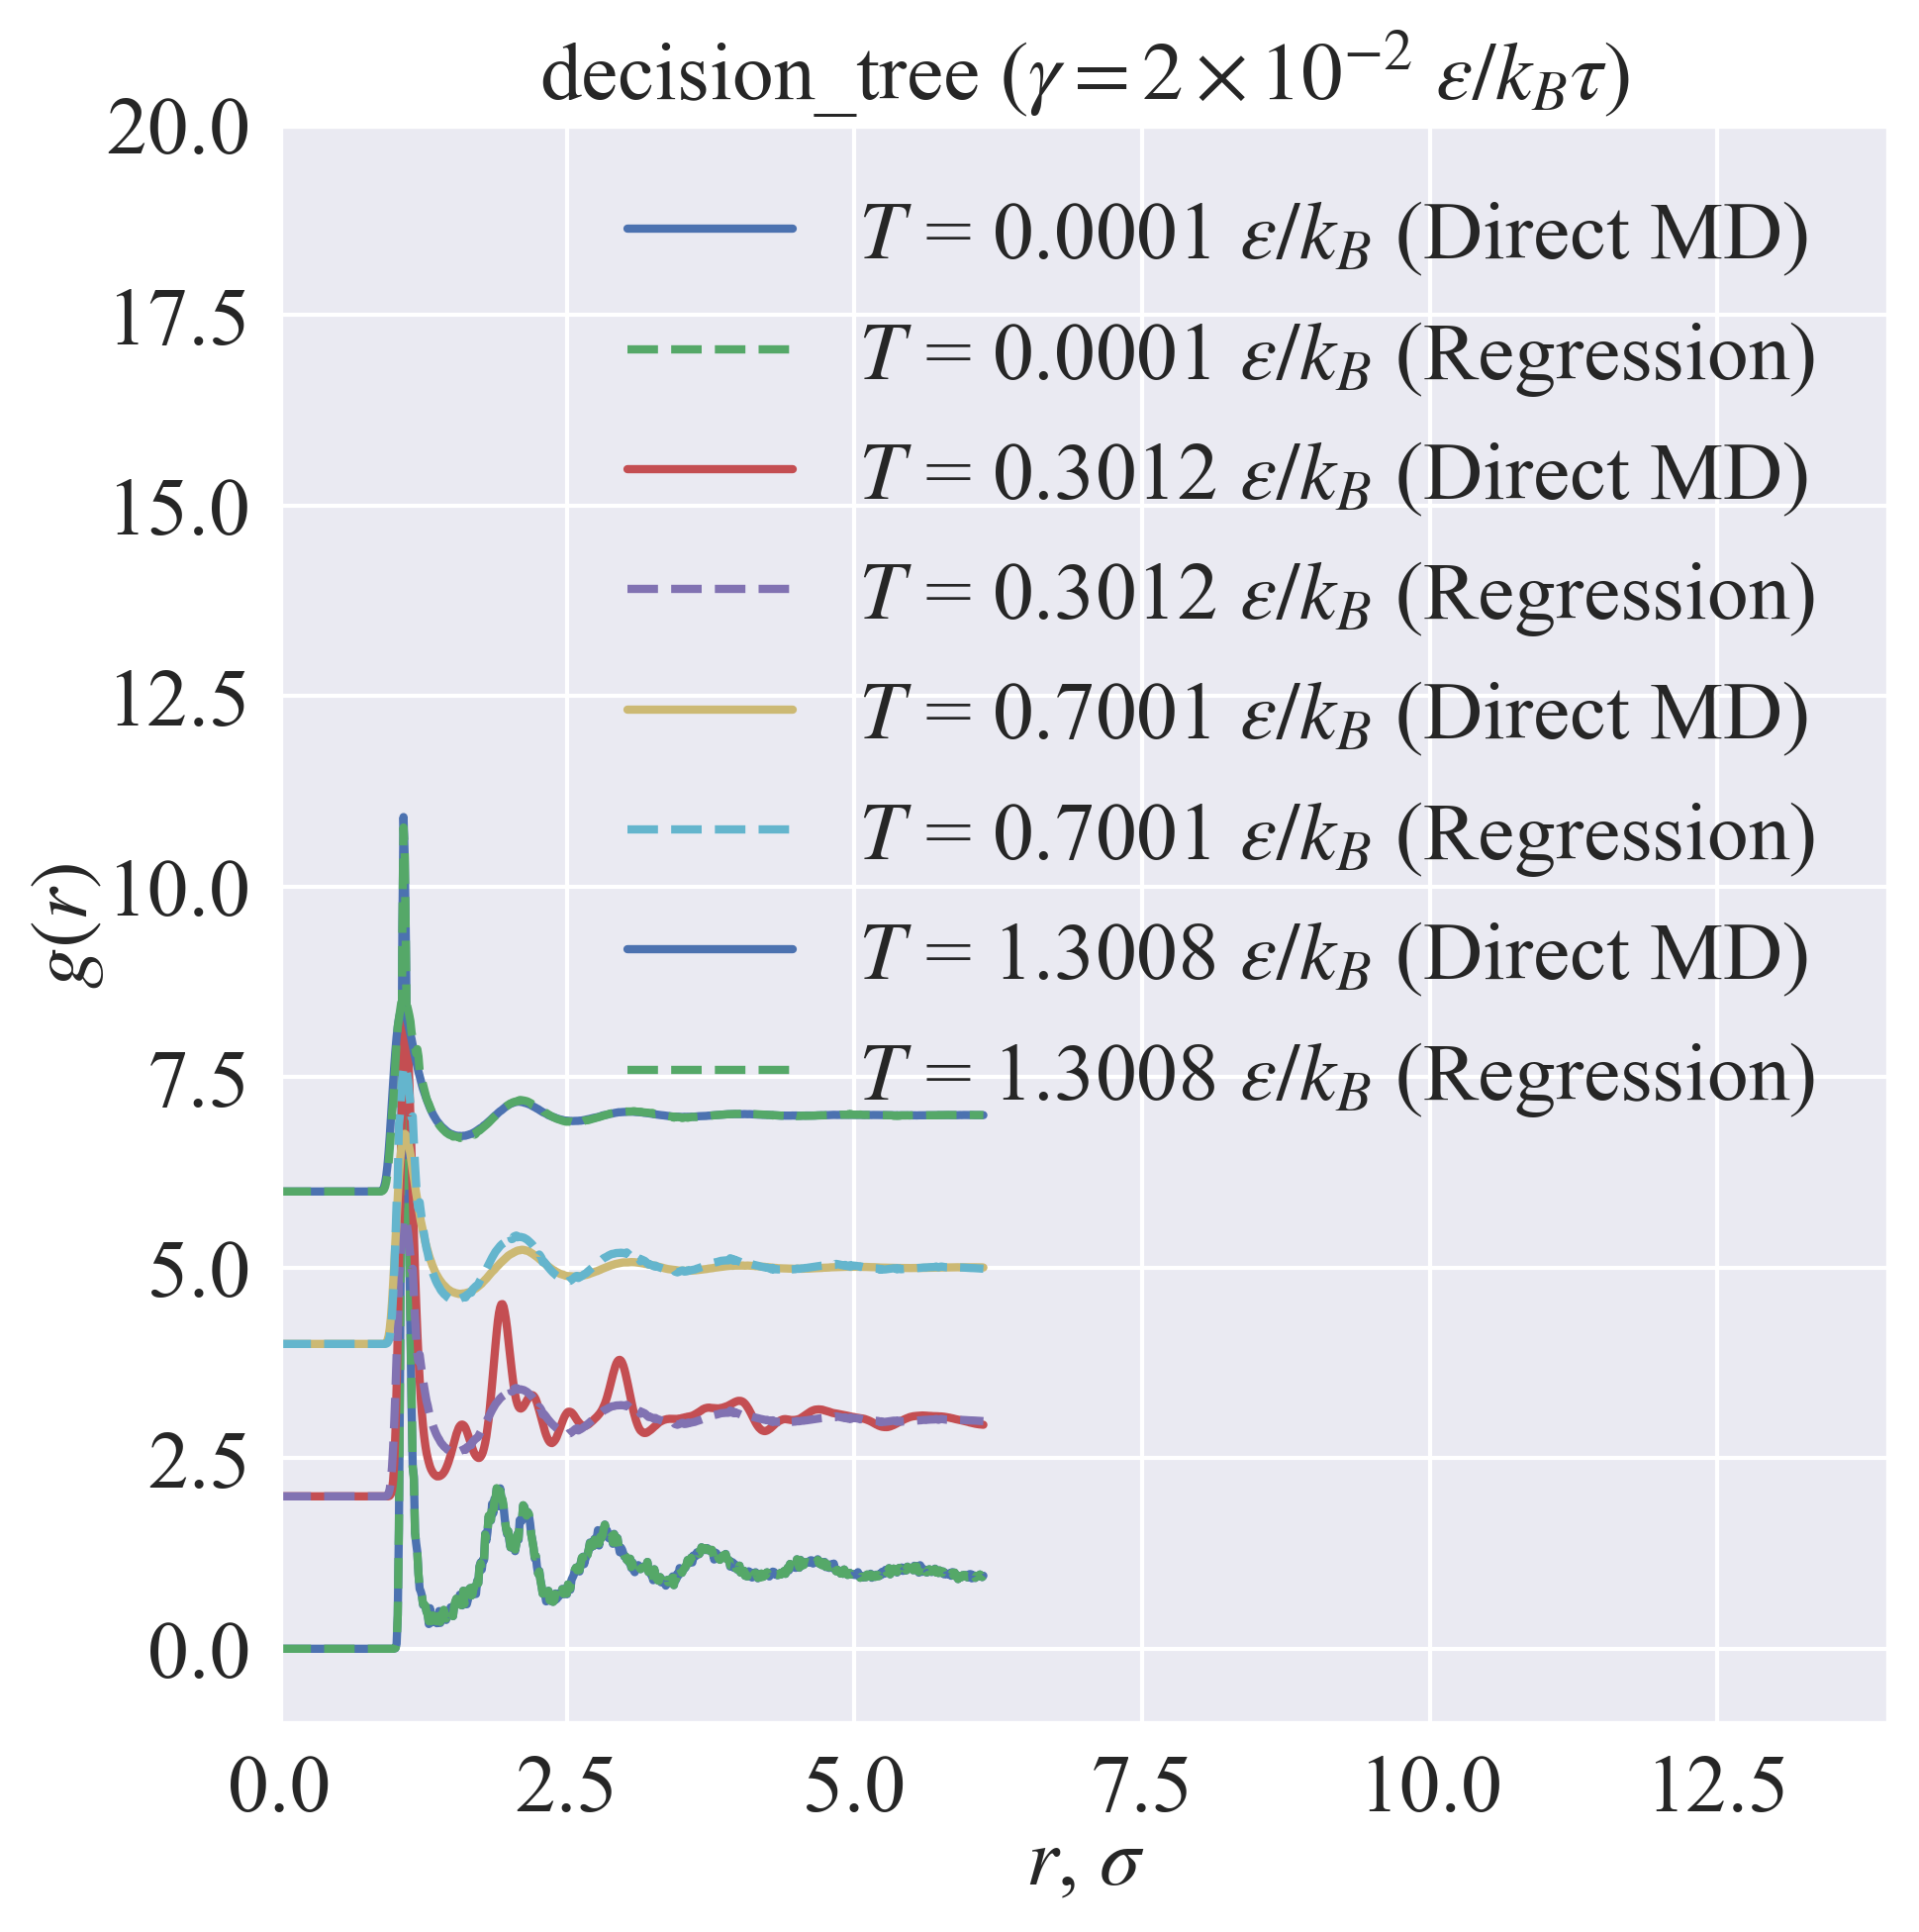

In [22]:
for key, value in predicted_rdf_points.items():
    plotter = Plotter(
        path_to_plots=PATH_TO_CURRENT_PLOTS,
        limits=dict(
            left=0,
            right=14,
            bottom=-1,
            top=20,
        ),
        size=(7, 7),
        labels=('radius', 'rdf'),
    )
    plotter.ax.set_title(fr'{key} ($\gamma = 2\times10^{{-2}}~\varepsilon / k_B\tau$)')
    shown_temperatures = []
    for i, setup in enumerate(setups_slow):
        temperature = setup["temperature"]
        if temperature not in predicted_temperatures:
            continue
        if round(temperature, 4) in shown_temperatures:
            continue
        else:
            shift_scale = 2
            plotter.ax.plot(
                rdf_slow.data['radius'],
                rdf_slow.data[f'setup_{i}'] + shift_scale * len(shown_temperatures),
                label=get_temperature_legend(temperature, 4) + ' (Direct MD)',
            )
            plotter.ax.plot(
                rdf_table.columns.values,
                value[temperature] + shift_scale * len(shown_temperatures),
                '--',
                label=get_temperature_legend(temperature, 4) + ' (Regression)',
            )
            shown_temperatures.append(round(temperature, 4))

    plotter.ax.legend()
    plotter.save_plot(f'rdf_with_predicted_cooling_{key}.png')
    plt.show()

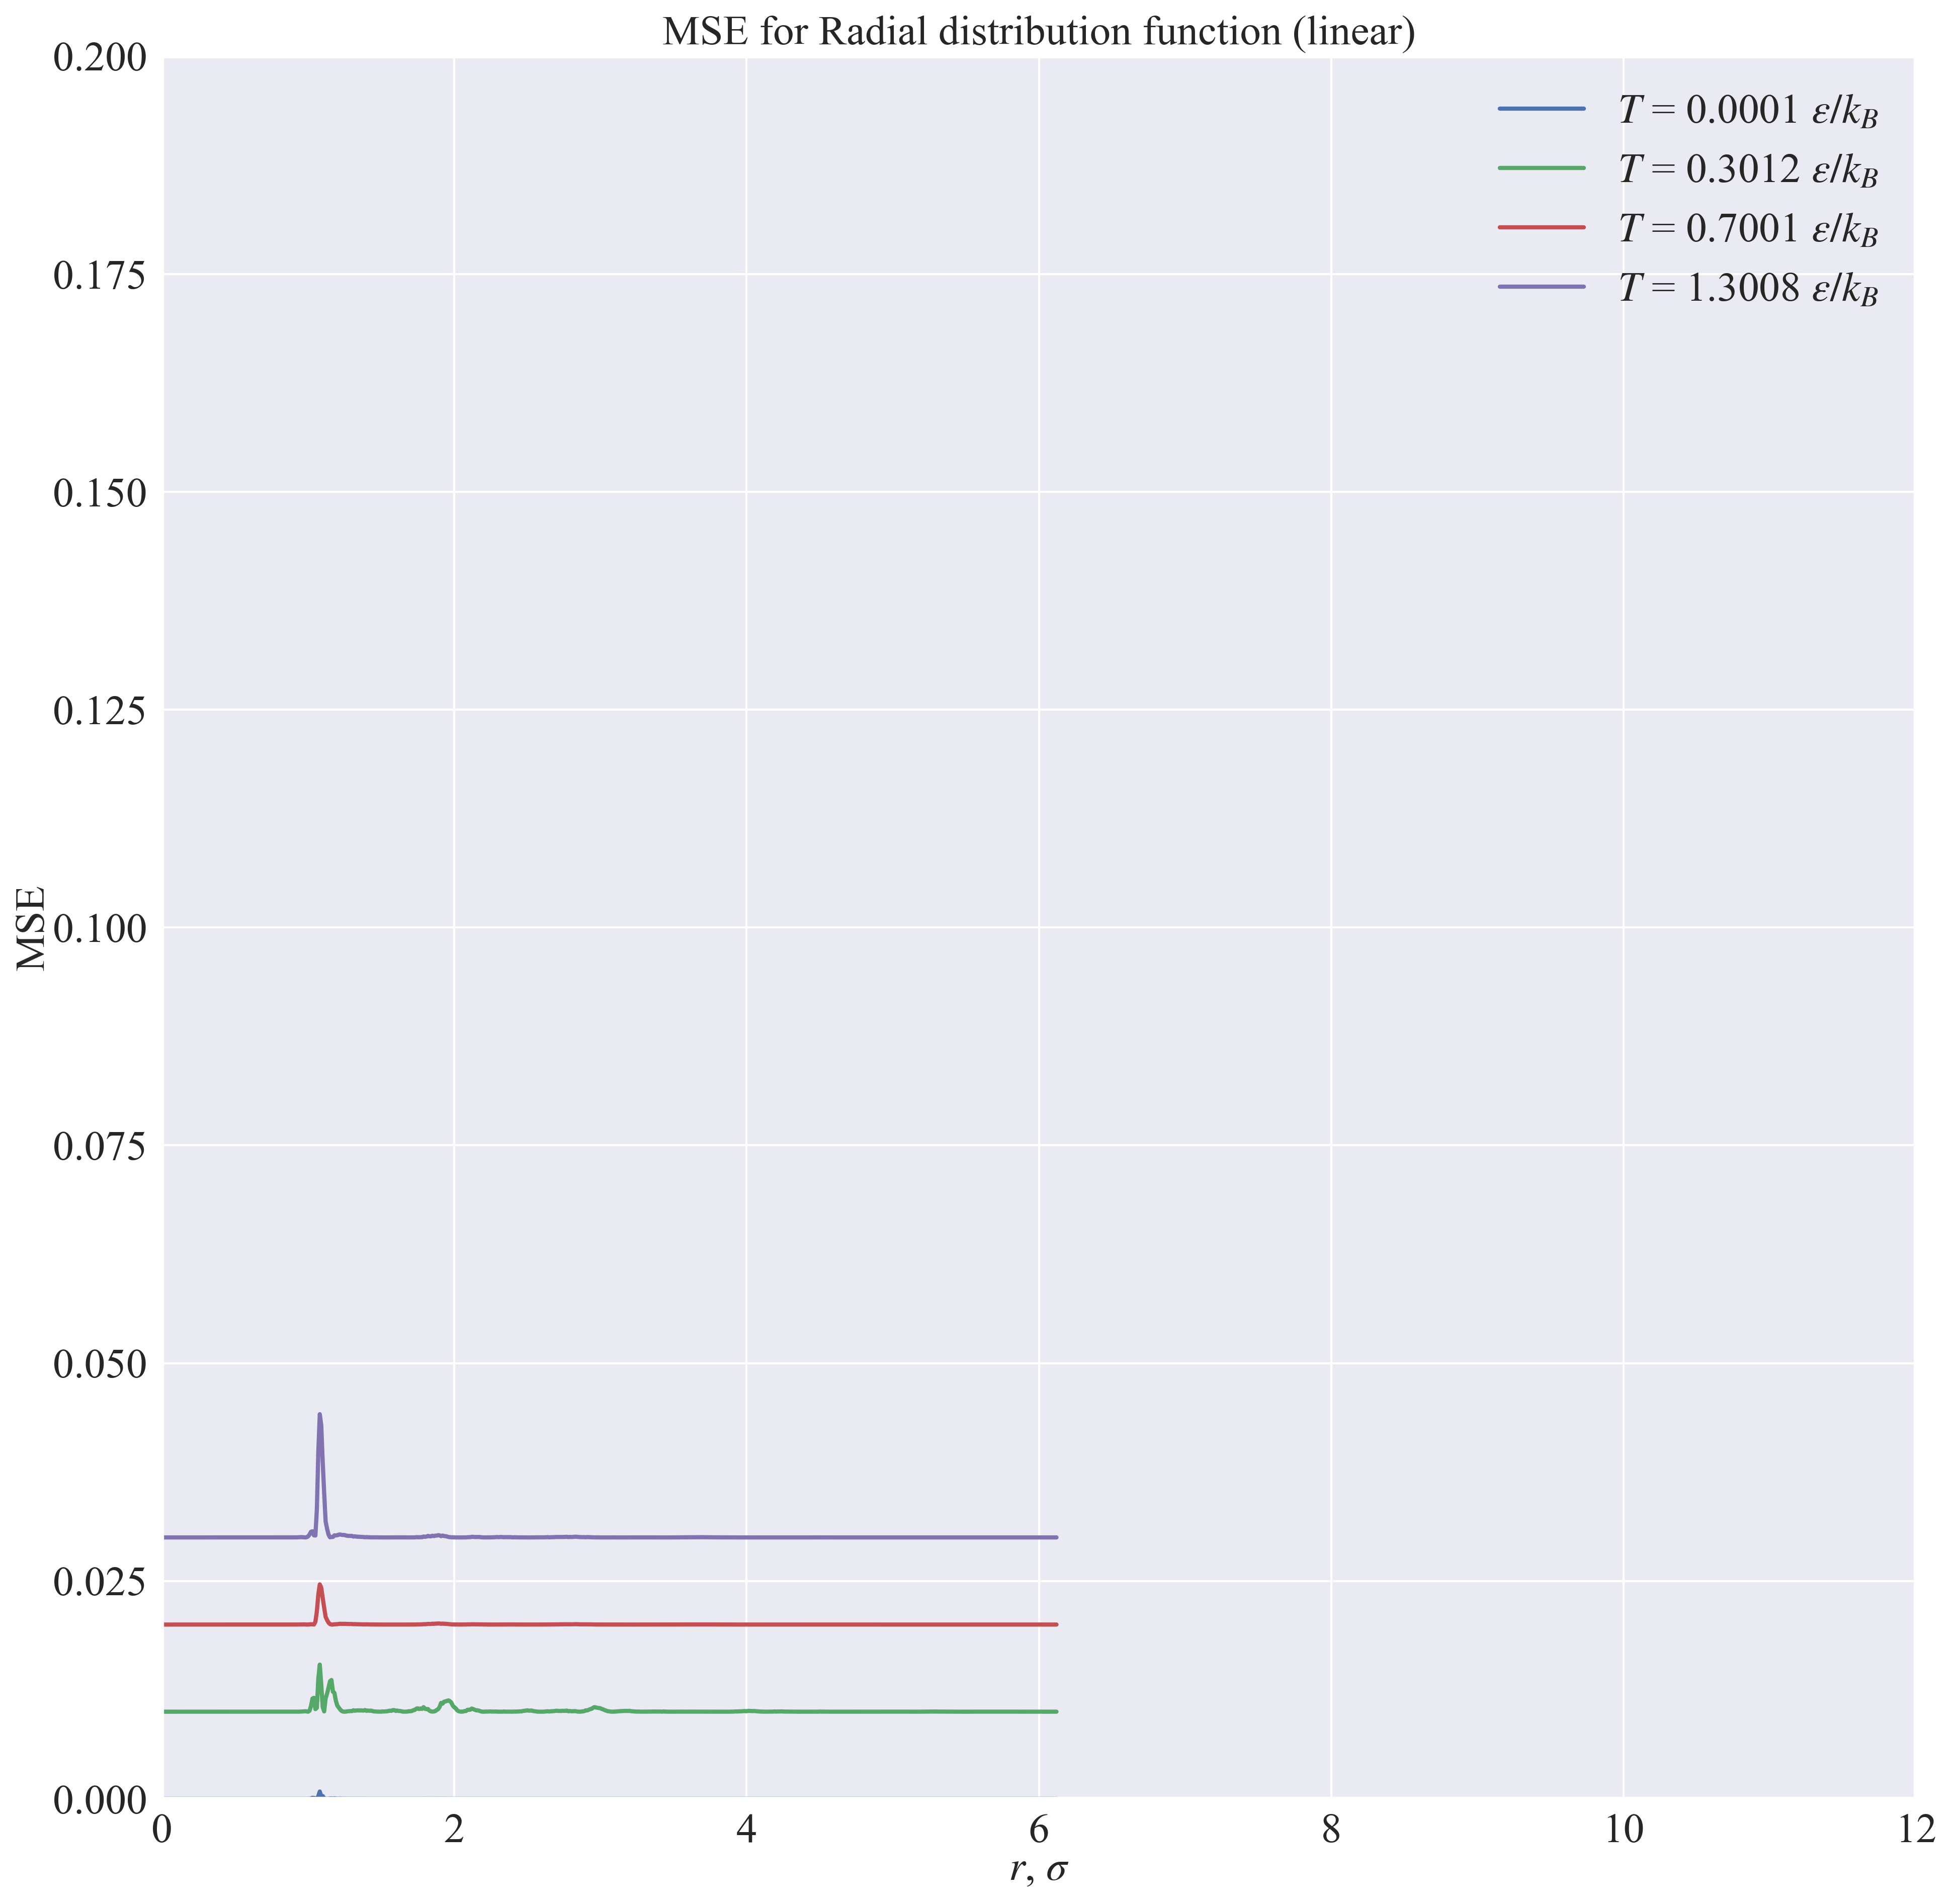

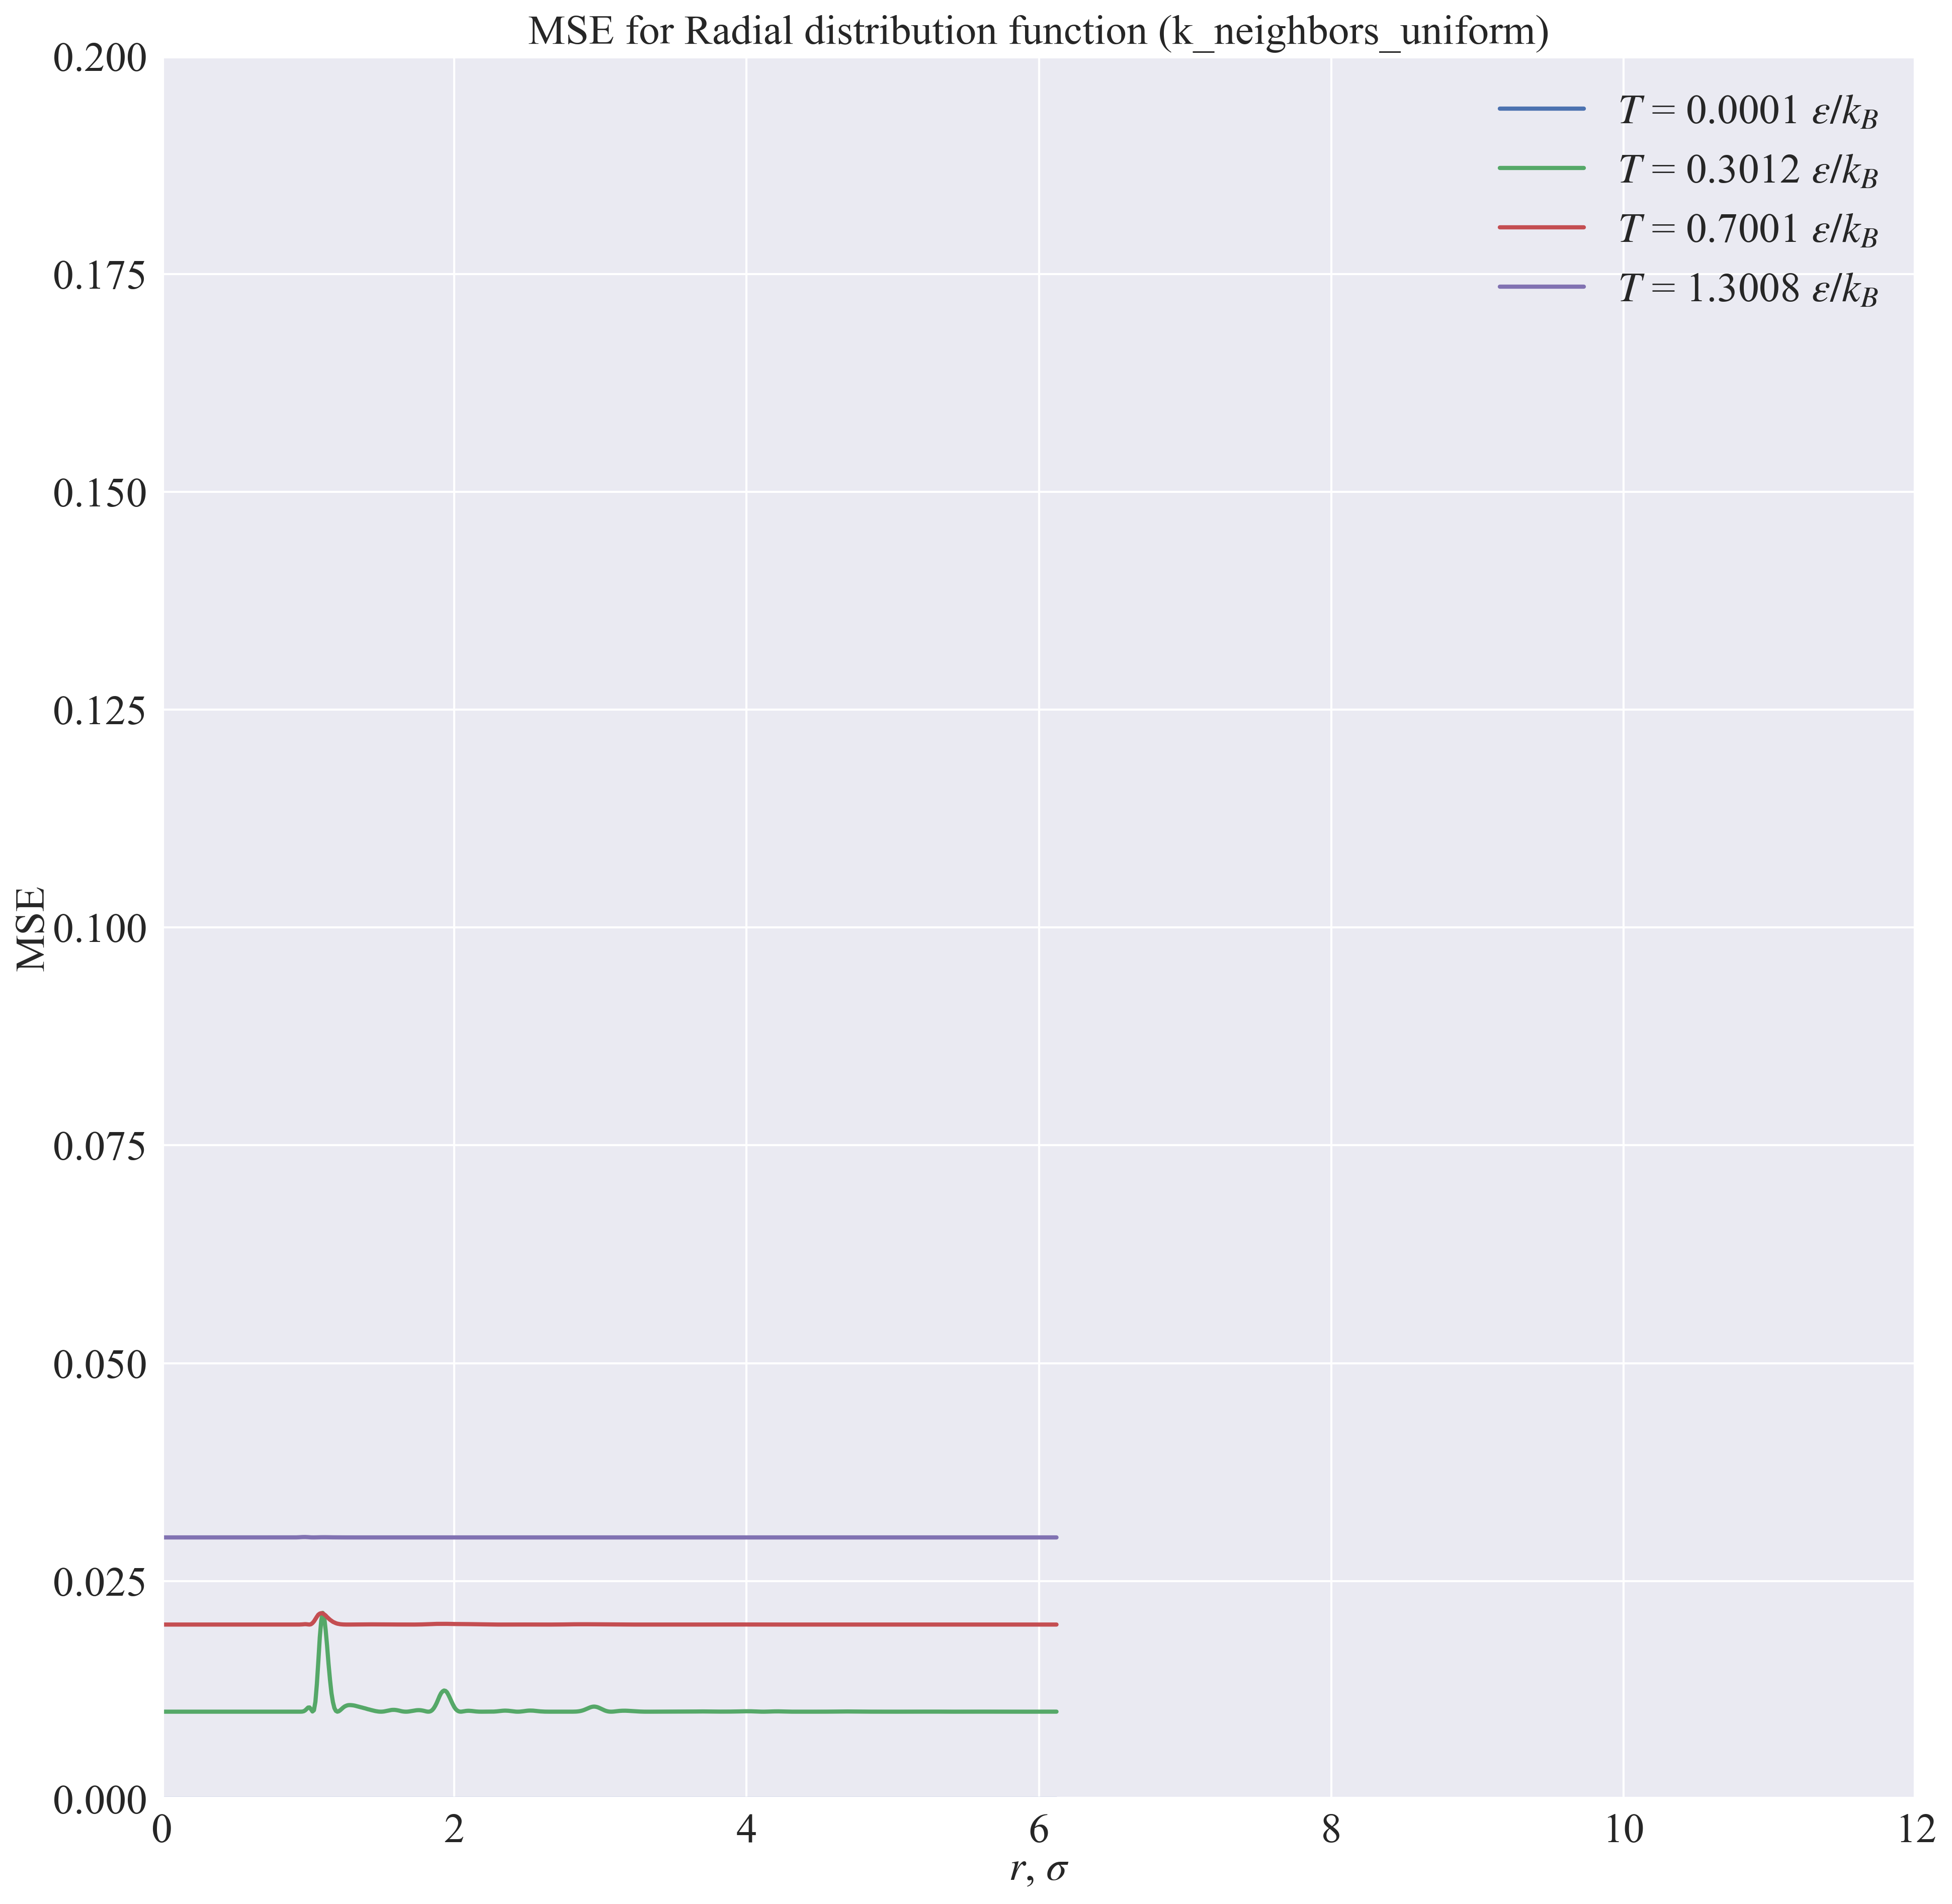

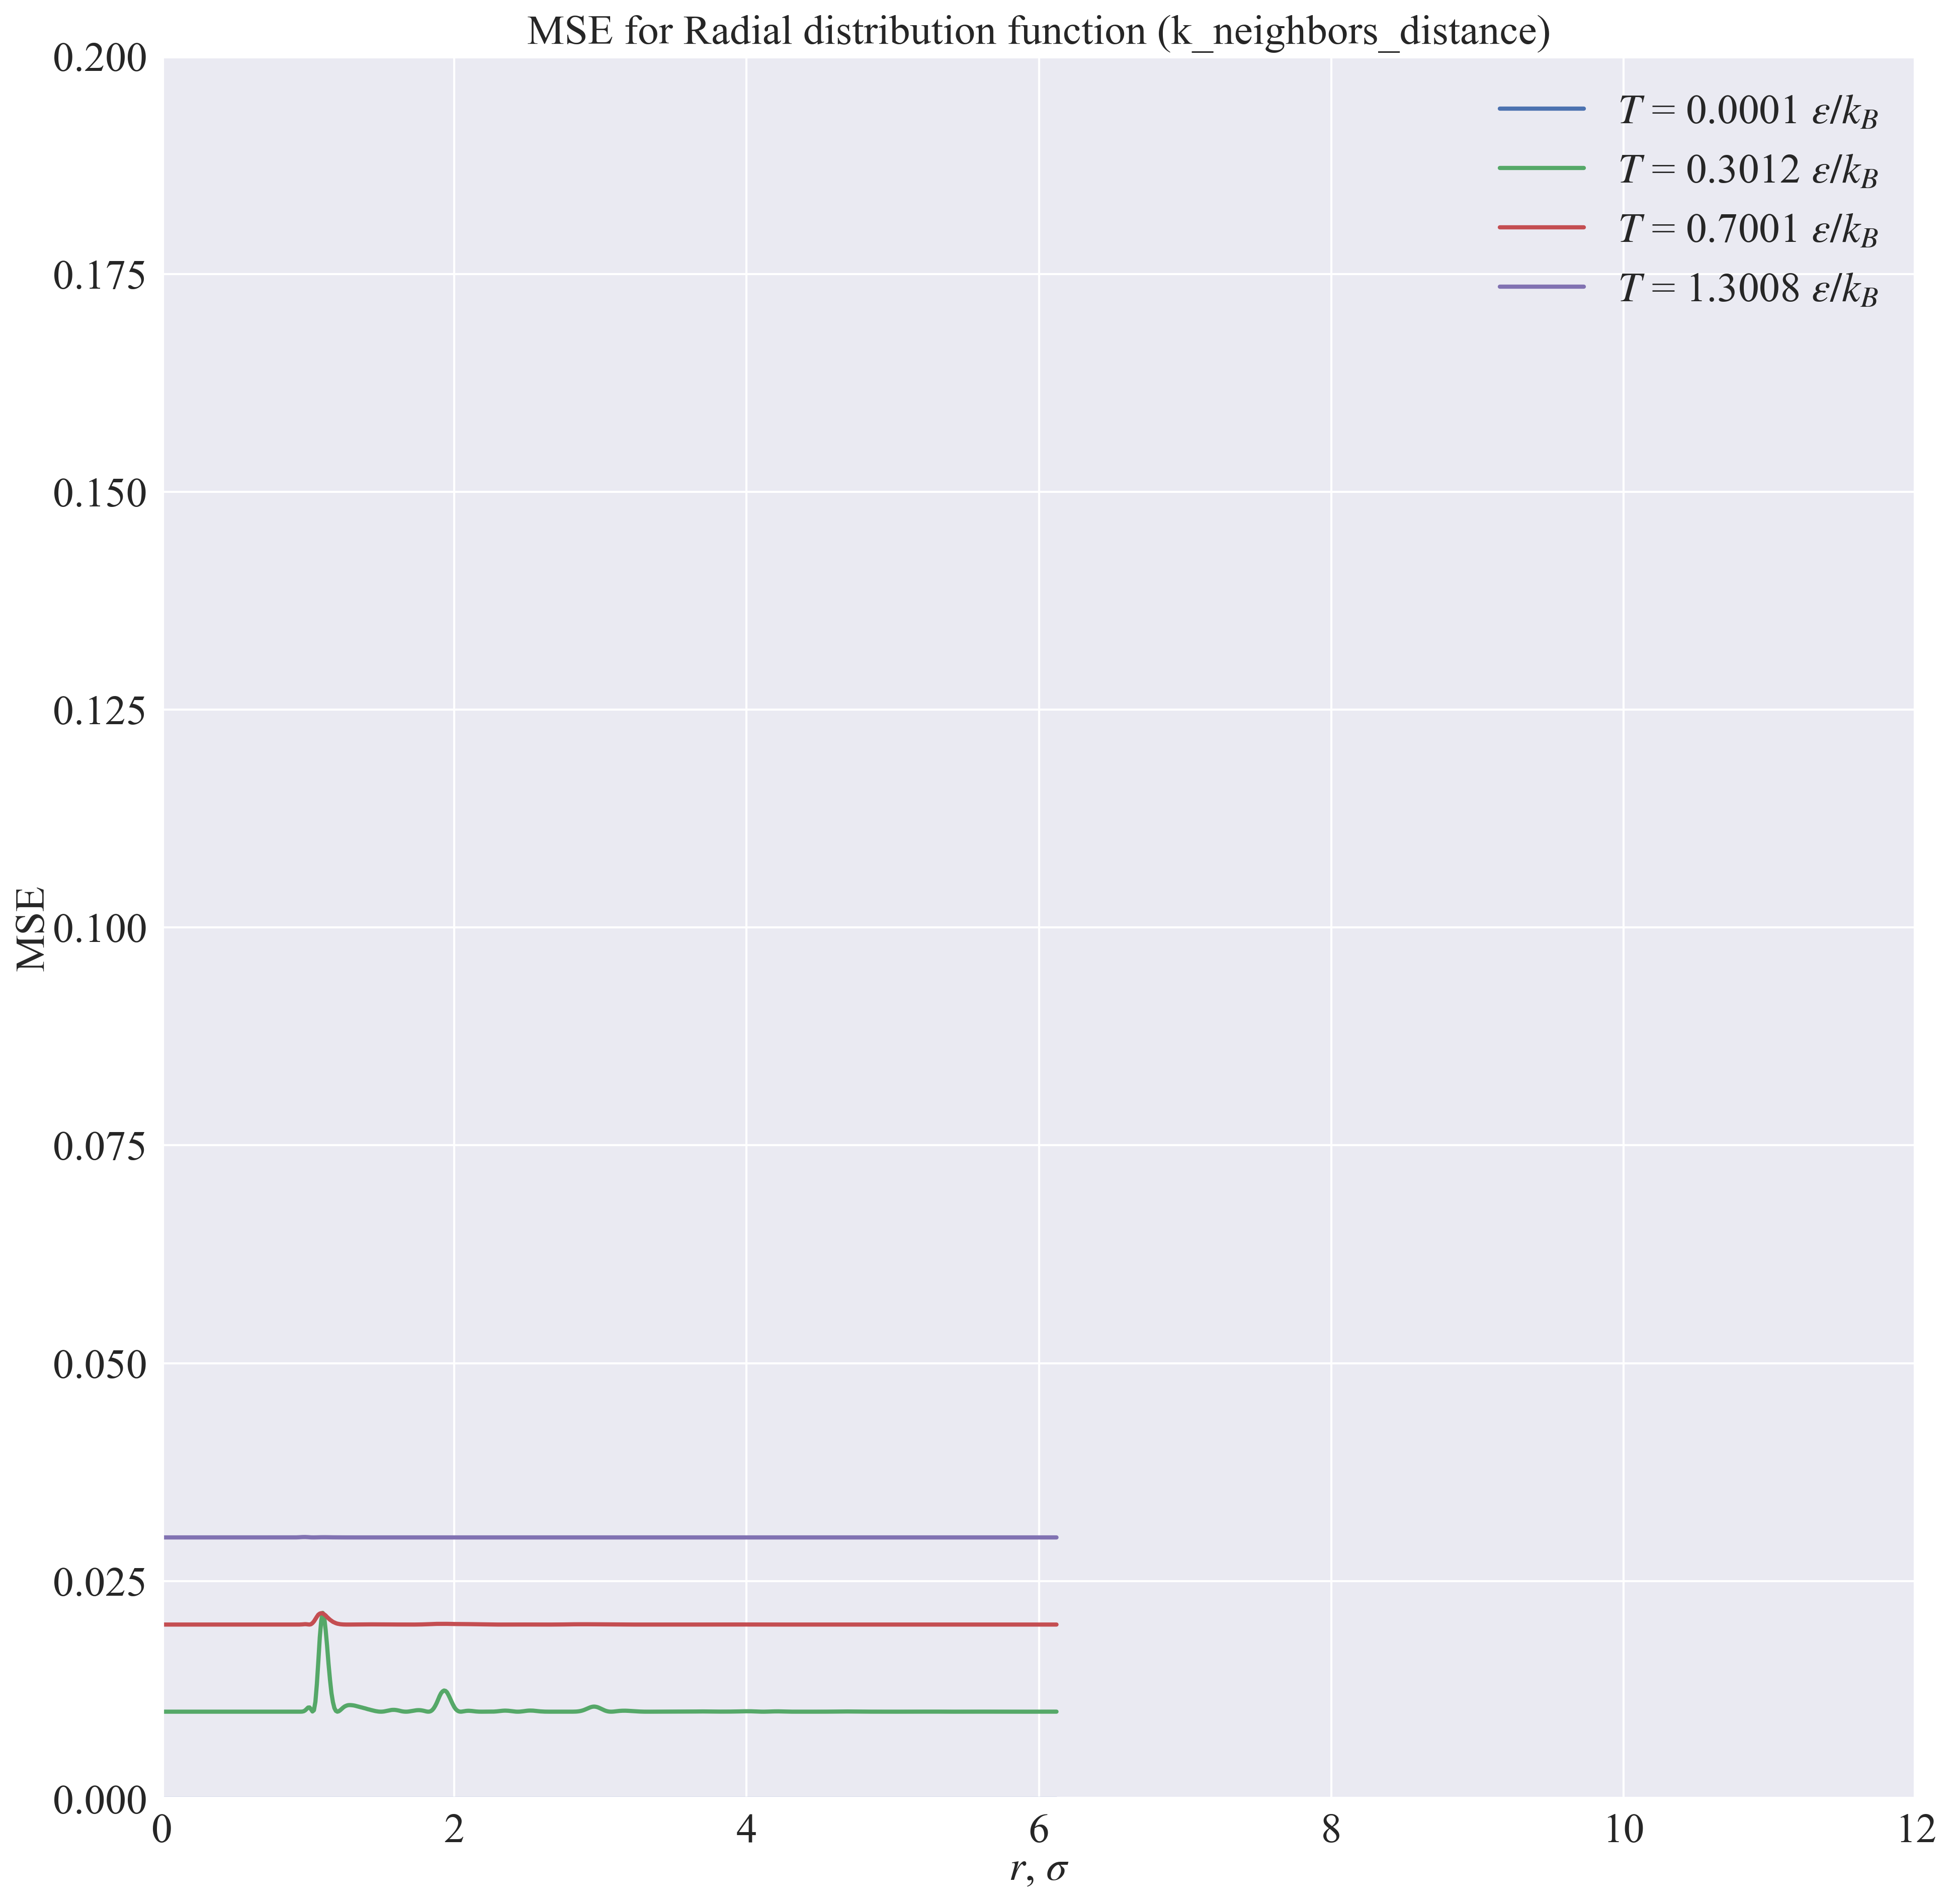

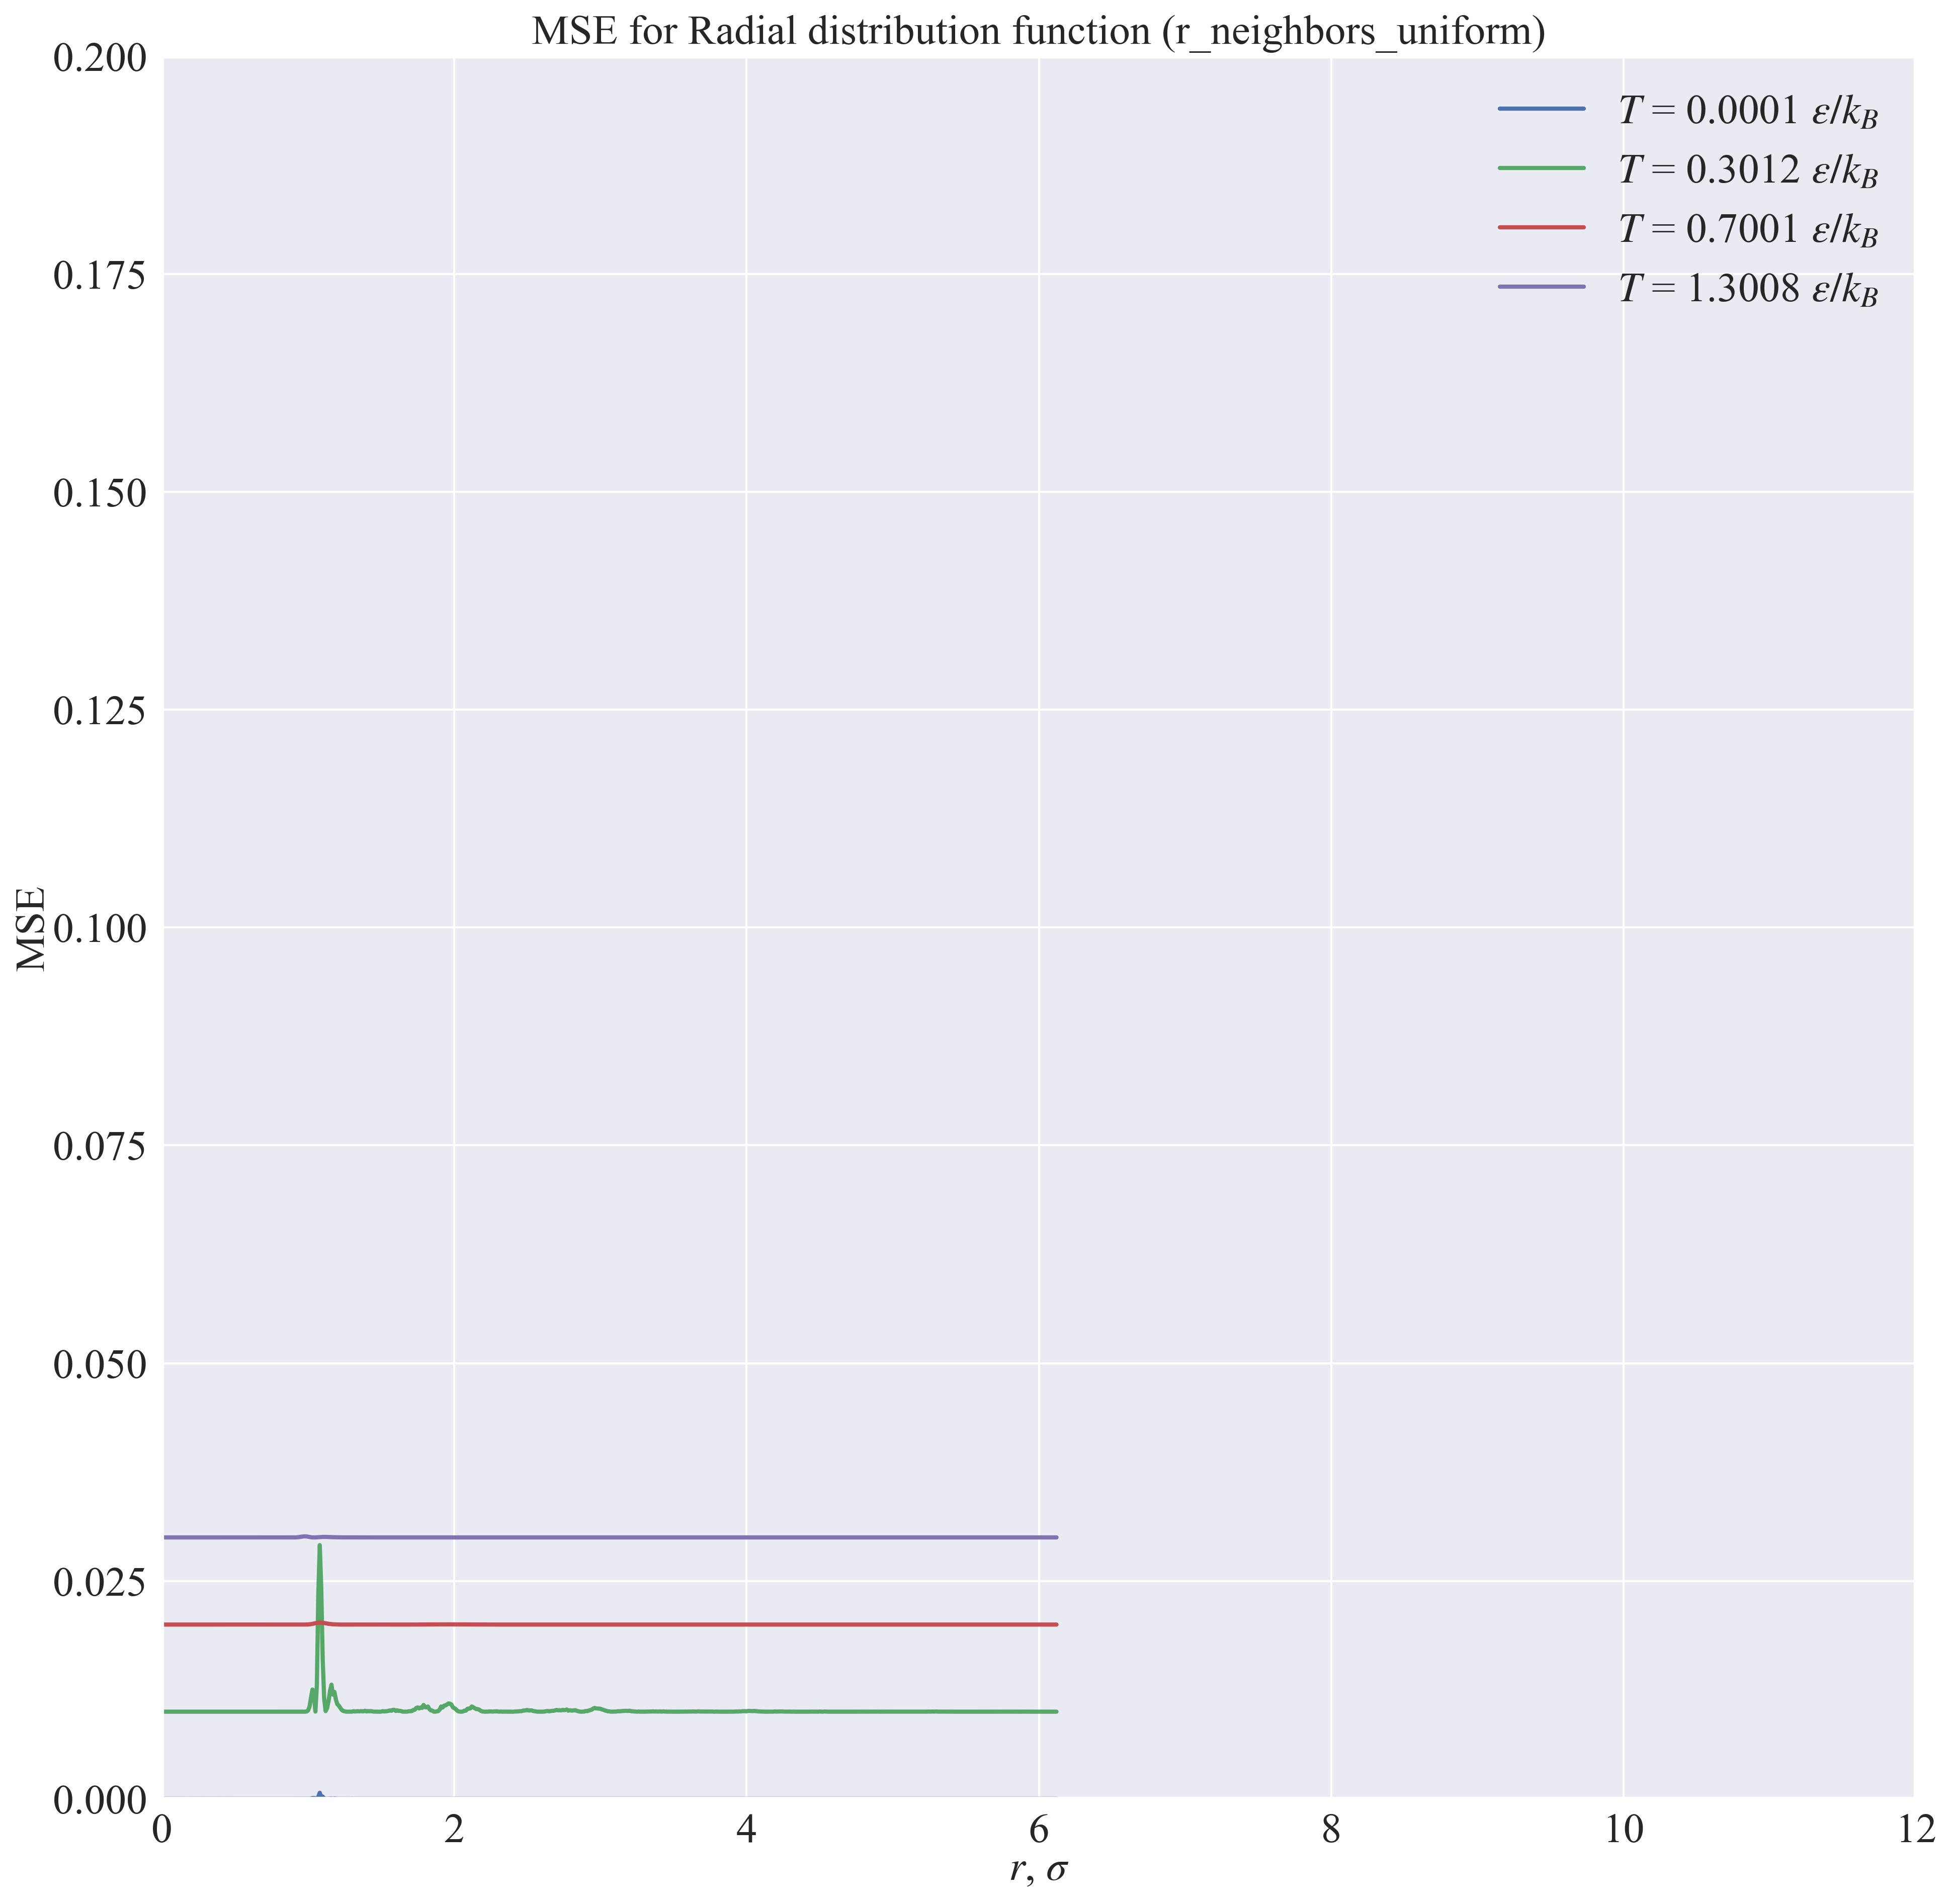

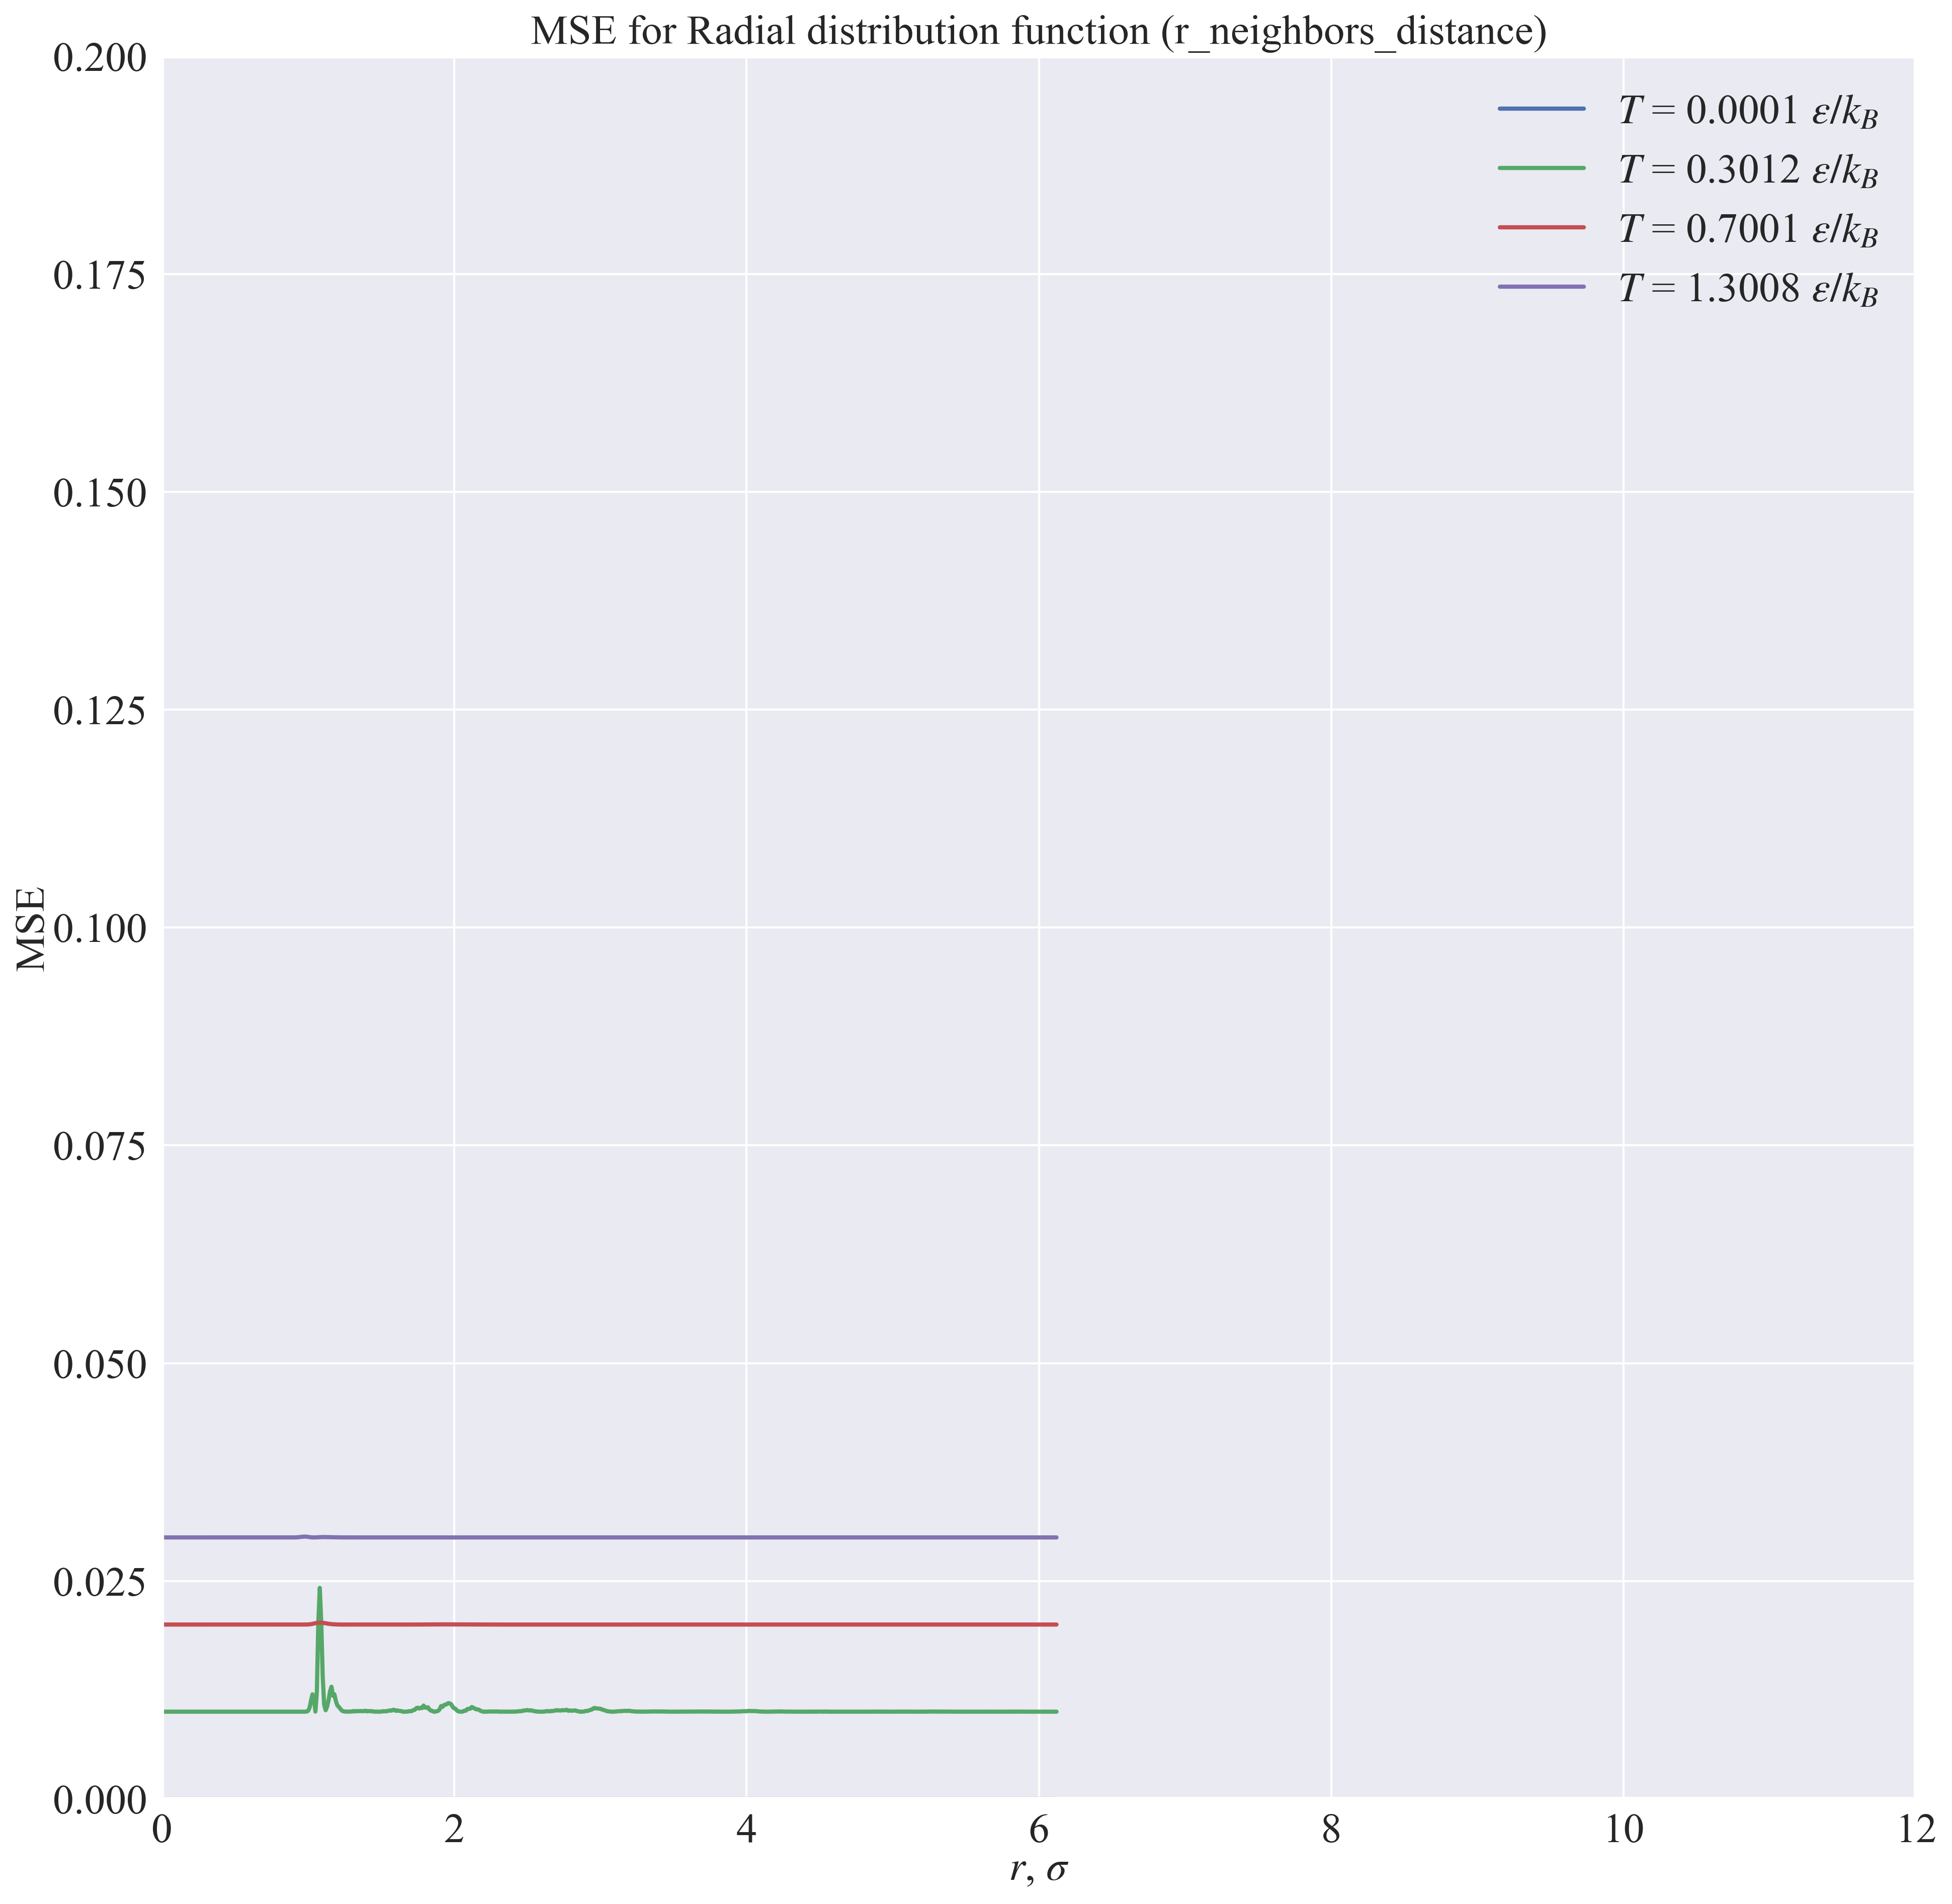

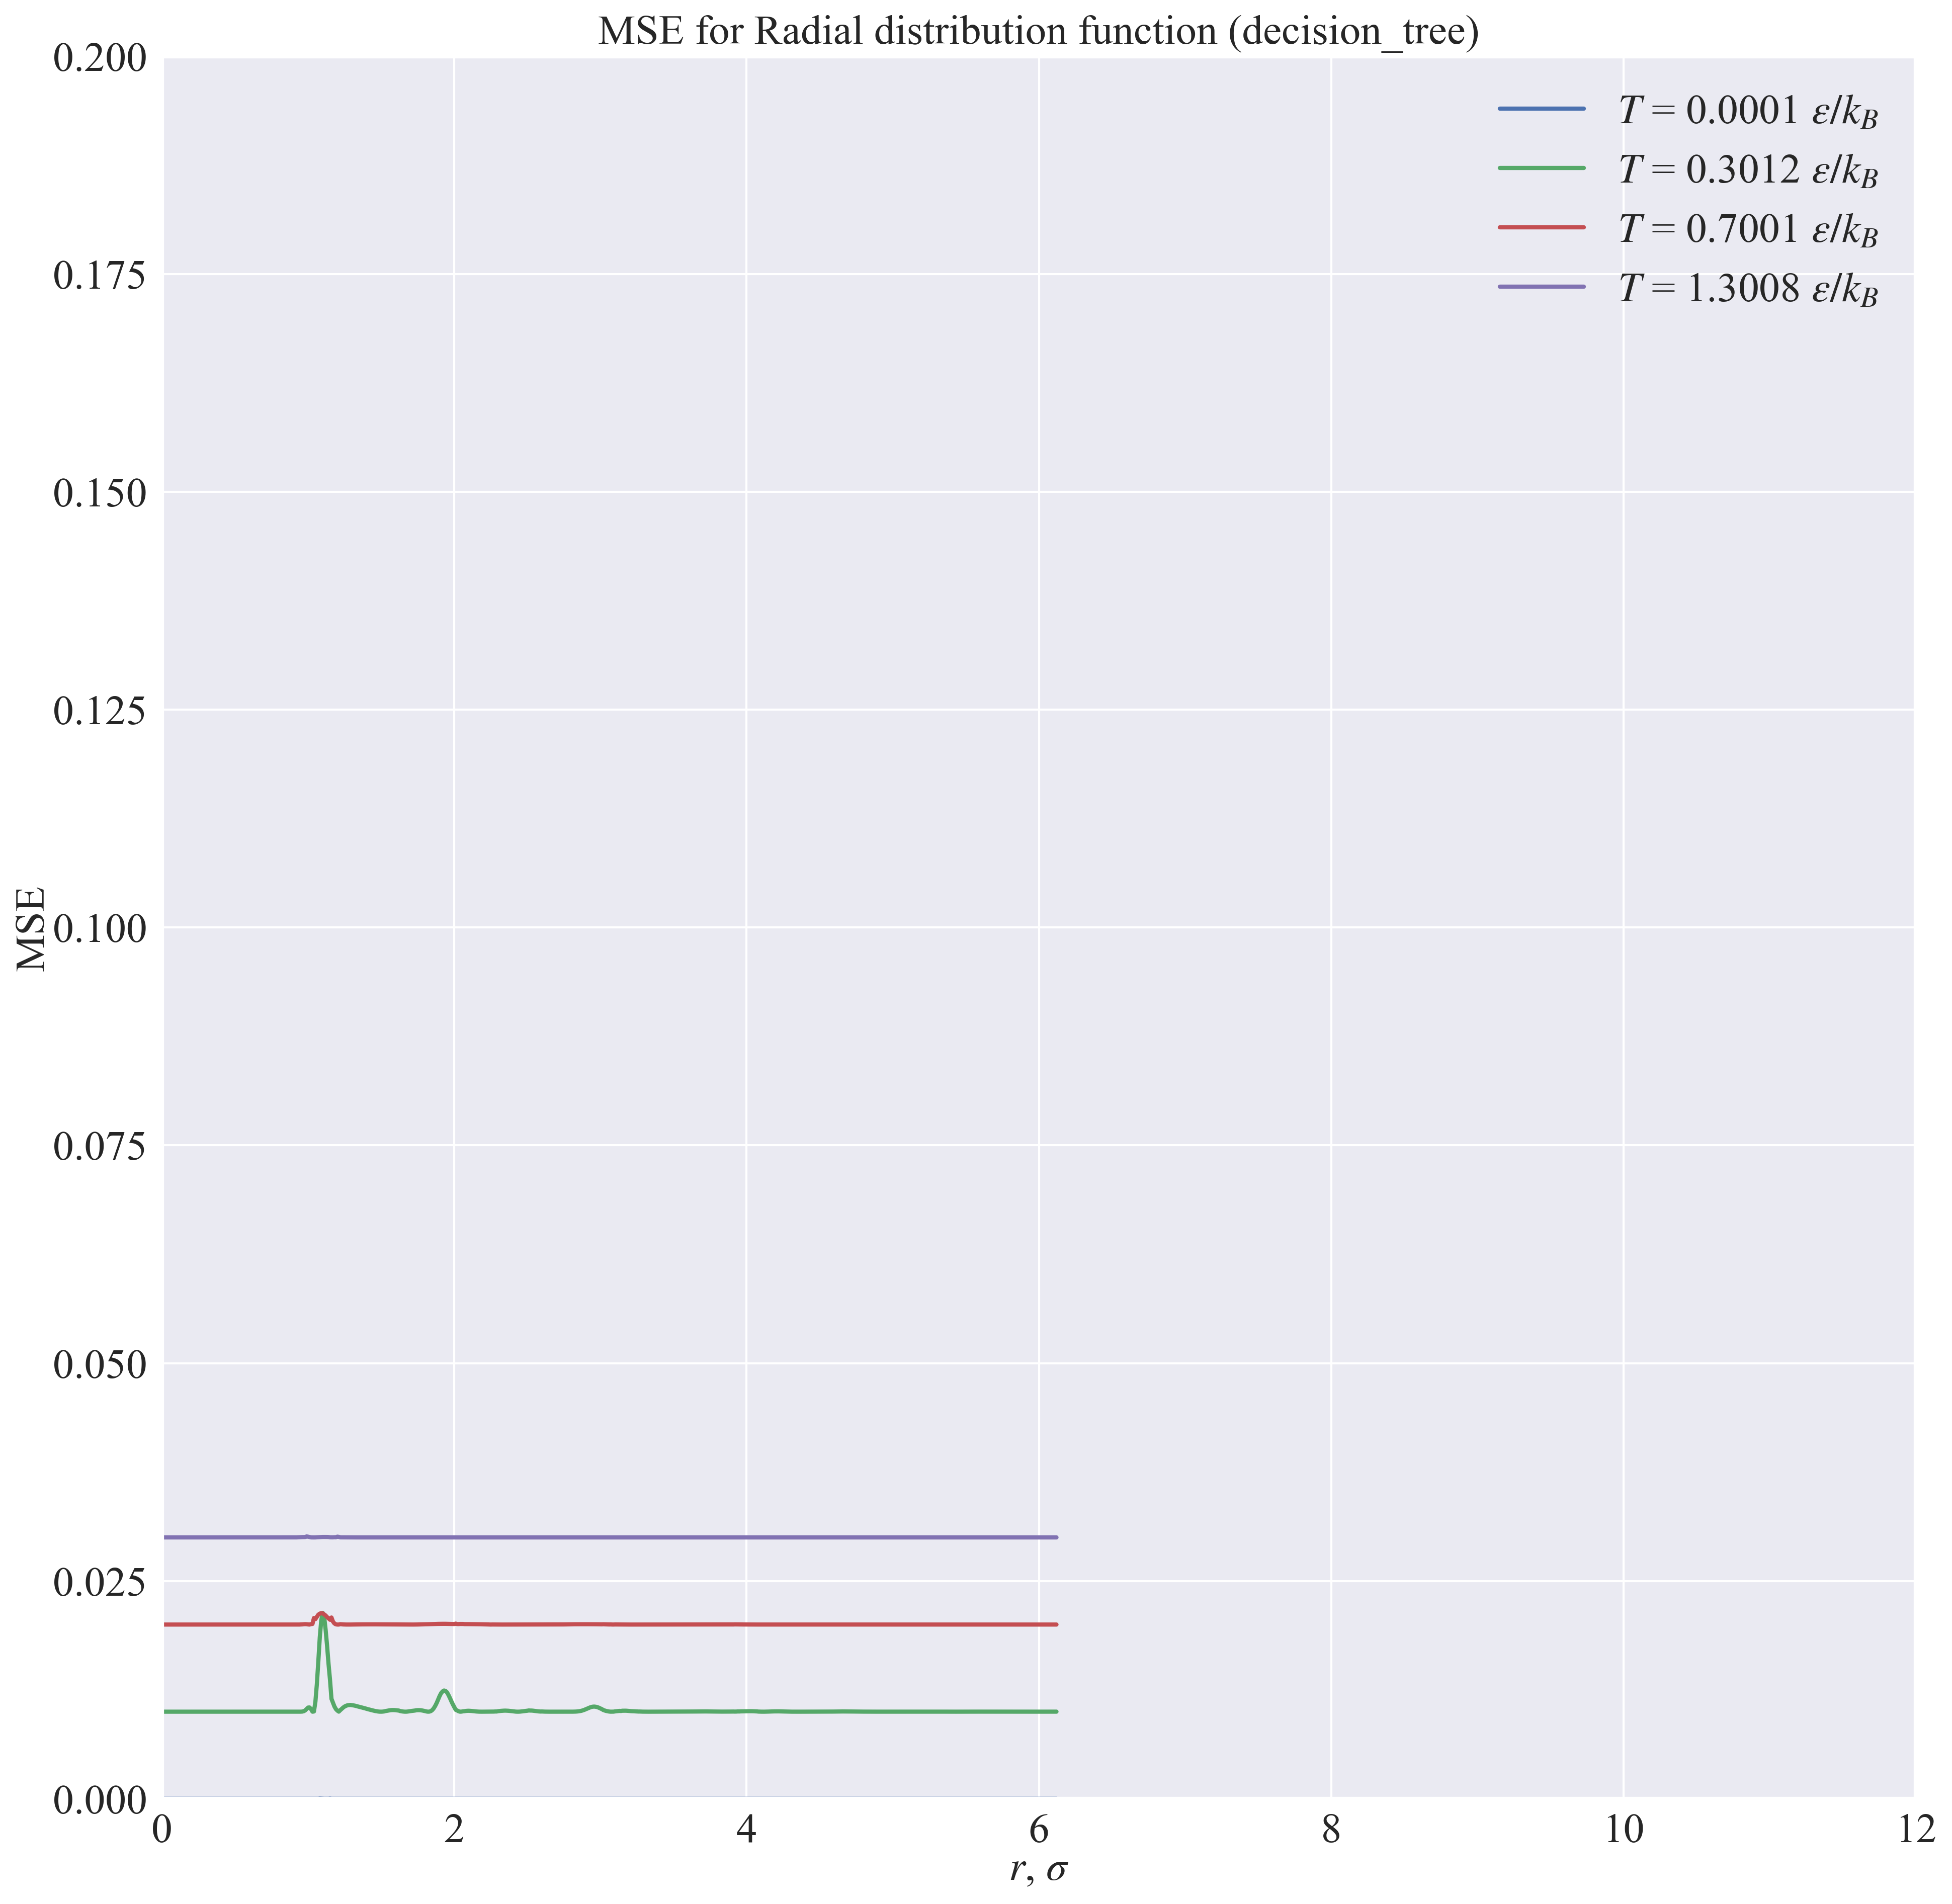

In [23]:
max_mse = {
    'names': [],
}

for key, value in predicted_rdf_points.items():
    name = ''.join([item[0].upper() for item in key.split('_')])
    max_mse['names'].append(name)
    
    plotter = Plotter(
        path_to_plots=PATH_TO_CURRENT_PLOTS,
        limits=dict(
            left=0,
            right=12,
            bottom=0,
            top=0.2,
        ),
        size=(15, 15),
        labels=('radius', 'MSE'),
    )
    plotter.ax.set_title(f'MSE for Radial distribution function ({key})')
    
    shown_temperatures = []
    for i, setup in enumerate(setups_slow):
        temperature = setup["temperature"]
        if temperature not in predicted_temperatures:
            continue
        if round(temperature, 4) in shown_temperatures:
            continue
        else:
            mse = (
                value[temperature]
                - rdf_slow.data[f'setup_{i}']
            ) ** 2 / rdf_table.columns.values.size
            try:
                max_mse[temperature].append(mse.max())
            except KeyError:
                max_mse[temperature] = [mse.max()]
            plotter.ax.plot(
                rdf_table.columns.values,
                mse + 0.01 * len(shown_temperatures),
                label=get_temperature_legend(temperature, 4),
            )
            shown_temperatures.append(round(temperature, 4))

    plotter.ax.legend()
    plotter.save_plot(f'rdf_mse_cooling_{key}.png')
    plt.show()

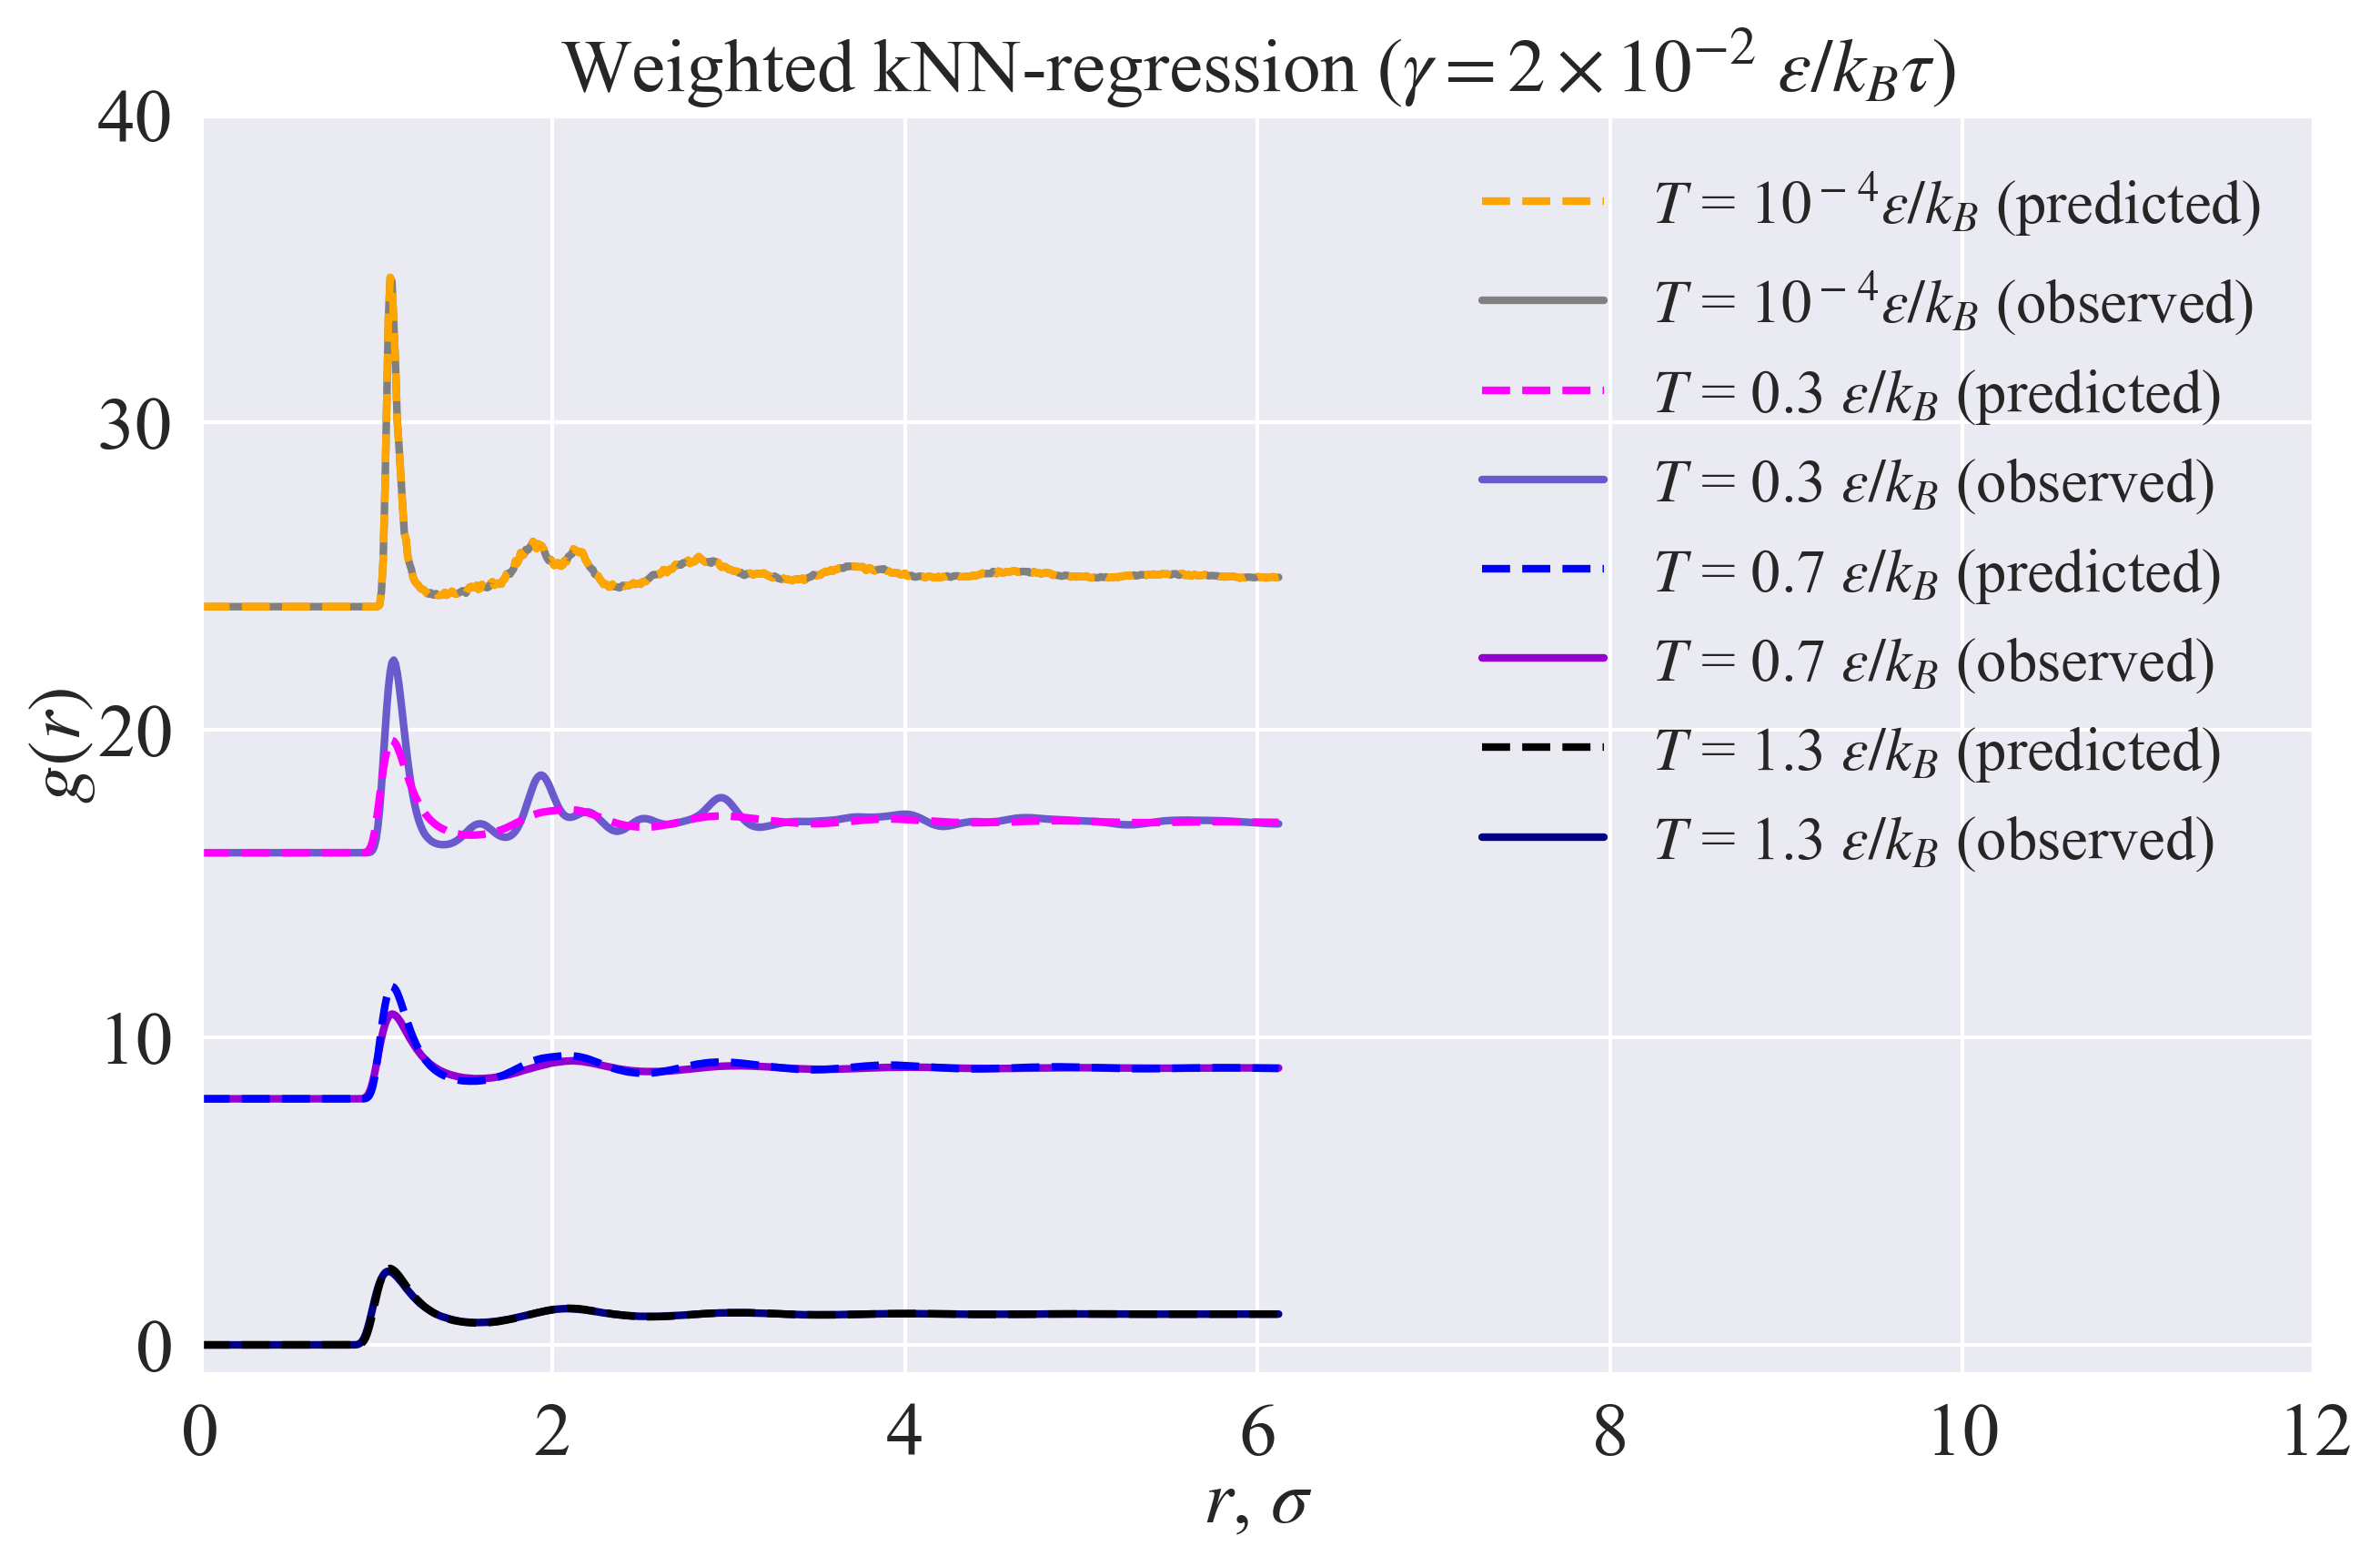

In [27]:
plotter = Plotter(
    path_to_plots=PATH_TO_CURRENT_PLOTS,
    limits=dict(
        left=0,
        right=12,
        bottom=-1,
        top=40,
    ),
    size=(10, 6),
    labels=('radius', 'rdf'),
)
plotter.ax.set_title(fr'Weighted kNN-regression ($\gamma = 2\times10^{{-2}}~\varepsilon / k_B\tau$)')
shown_temperatures = []
setups_size = len(setups_slow)
for i, setup in enumerate(setups_slow[::-1]):
    temperature = setup["temperature"]
    if temperature not in predicted_temperatures:
        continue
    if round(temperature, 4) in shown_temperatures:
        continue
    else:
        shift_scale = 8
        plotter.ax.plot(
            rdf_slow.data['radius'],
            rdf_slow.data[f'setup_{setups_size - i - 1}'] + shift_scale * len(shown_temperatures),
            label=get_temperature_legend(temperature, 2) + ' (observed)',
            color=COLORS[setups_size - i],
        )
        plotter.ax.plot(
            rdf_table.columns.values,
            predicted_rdf_points['k_neighbors_distance'][temperature] + shift_scale * len(shown_temperatures),
            '--',
            label=get_temperature_legend(temperature, 2) + ' (predicted)',
            color=COLORS[i],
        )
        shown_temperatures.append(round(temperature, 4))
        
handles, labels = plotter.ax.get_legend_handles_labels()
plotter.get_legend(handles[::-1], labels[::-1], fontsize=16)
plotter.save_plot(f'rdf_with_predicted_cooling_knn_distance.png')
plt.show()

In [25]:
max_mse['names']

['L', 'KNU', 'KND', 'RNU', 'RND', 'DT']

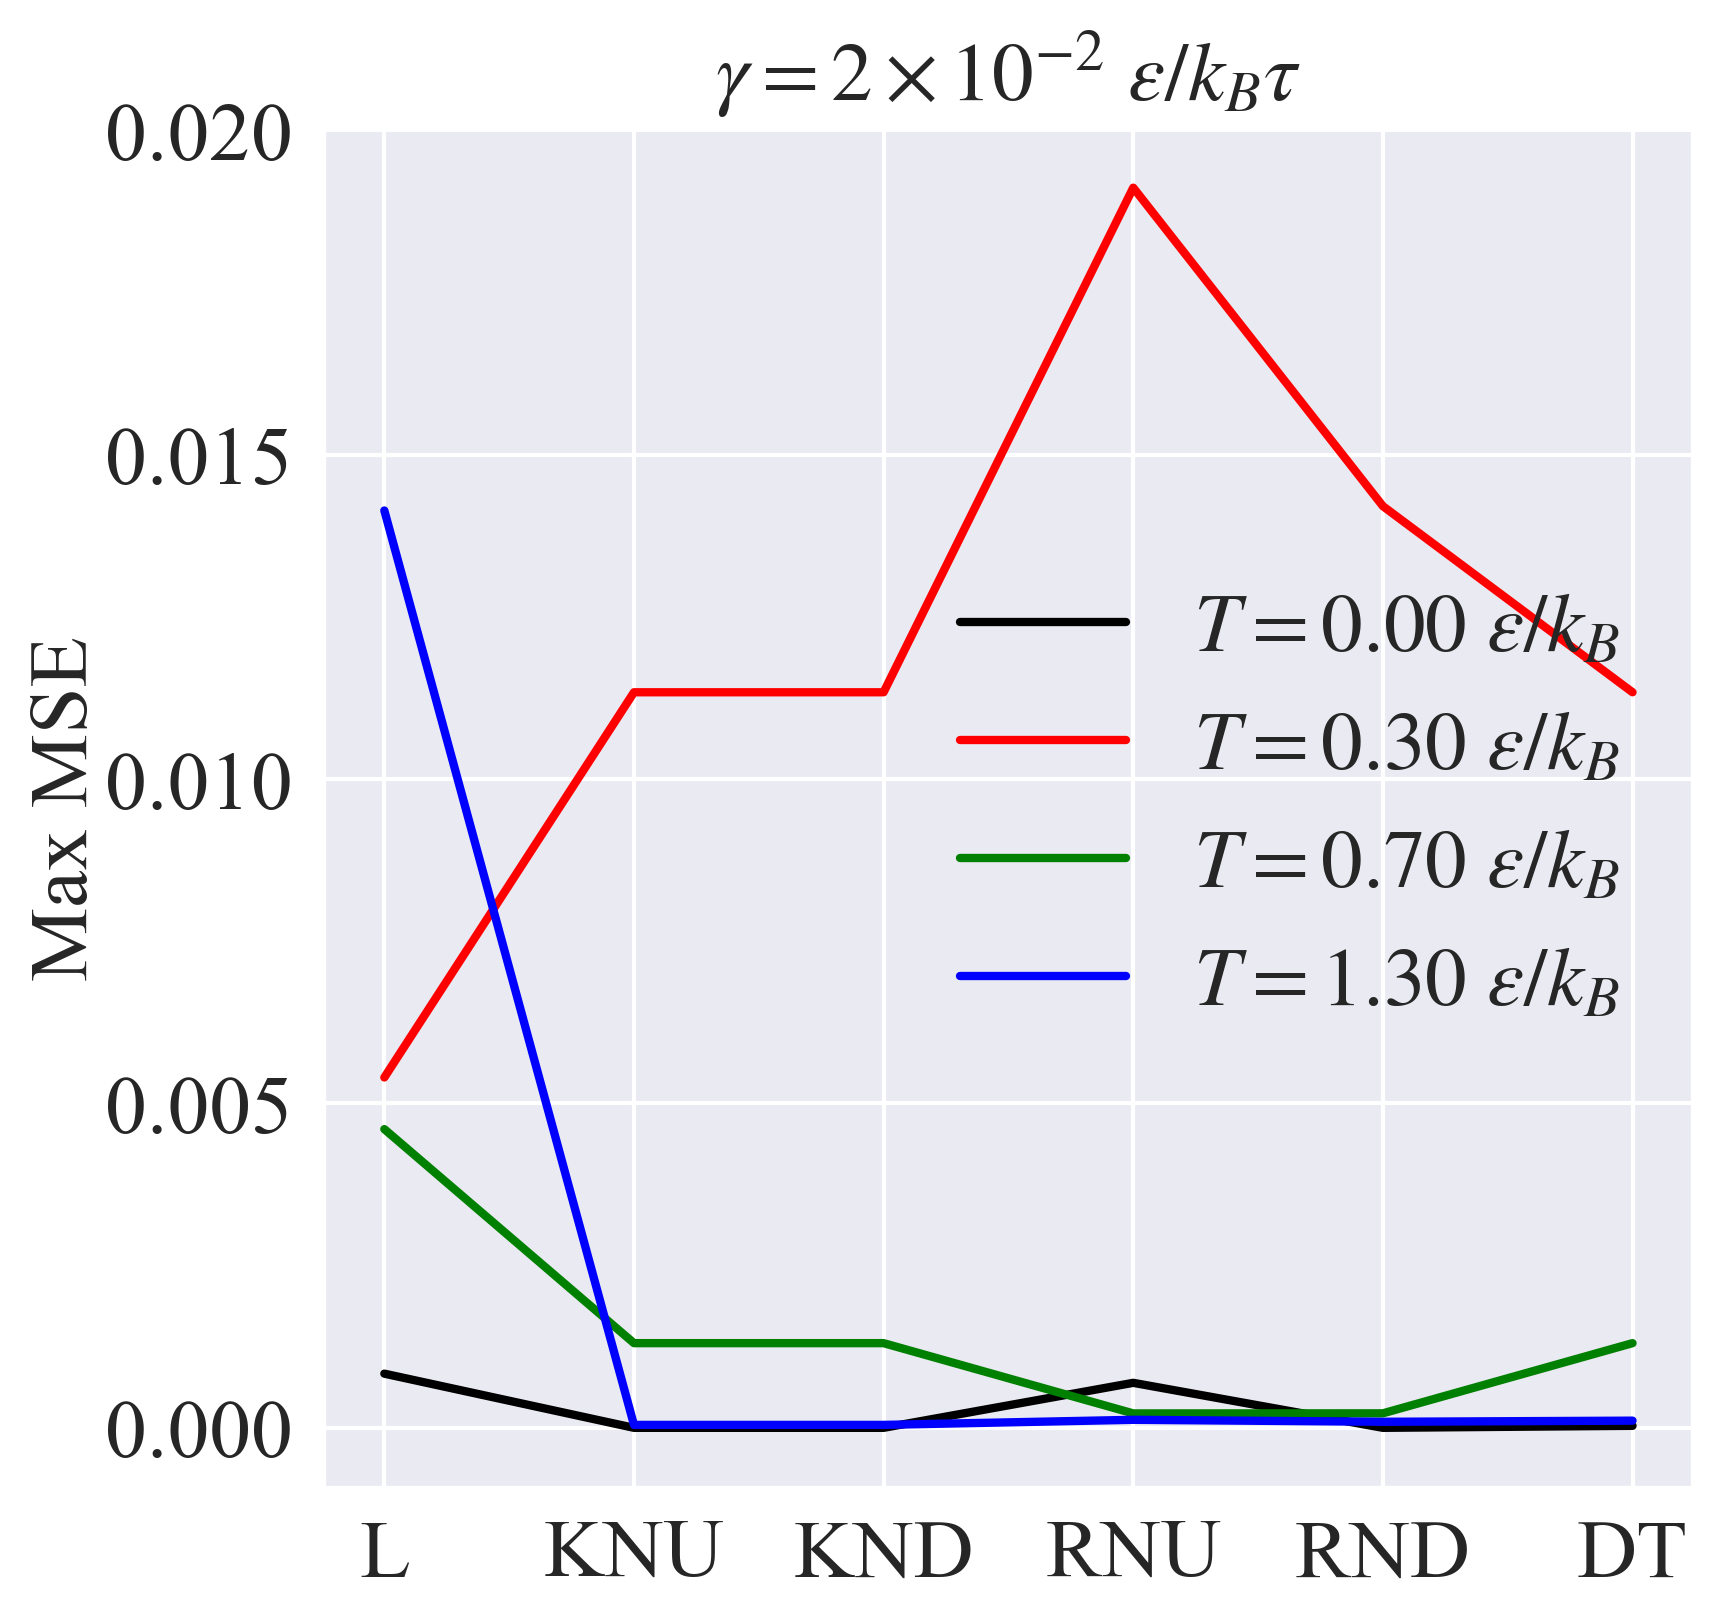

In [26]:
fig, ax = plt.subplots()
i = 0
for temperature, values in max_mse.items():
    if isinstance(temperature, float):
        x = list(range(len(values)))
        ax.plot(x, values, label=fr'$T = {temperature:.2f}~\epsilon / k_B$', color=COLORS[i])
        i += 1
ax.set_xticks(x)
ax.set_xticklabels(max_mse['names'])
ax.set_ylabel('Max MSE')
ax.legend()
ax.set_title(r'$\gamma = 2\times10^{{-2}}~\varepsilon / k_B\tau$')
save_plot(f'max_mse.png')